# Predcition of Hospital Admission Related to Infections

In this notebook, we develop a Cox proportional hazard regression model to predict the risk of hospital admission for common infections including urinary tract infection (sinusitis), upper respiratory tract infection (sinusitis), lower respiratory tract infection (sinusitis), sinusitis, otitis media or middle ear infection (ot media), and ear infection or otitis externa (ot externa).

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
from patsy import dmatrices
from lifelines import CoxPHFitter
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import pickle
from sklearn.preprocessing import PolynomialFeatures
from lifelines.utils import k_fold_cross_validation
from lifelines.utils import concordance_index
from lifelines.calibration import survival_probability_calibration
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibrationDisplay
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
import sys
from contextlib import redirect_stdout
# %matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


## 0- Functions

In [3]:
# def create_lineplot(data, var, title, legend_title, ax1):
def create_lineplot(data, var, title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    # a.Freq = a.Freq*1000
    a = a[a.Freq > 5]
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
#     ax1.legend(title=legend_title)
    # ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [4]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [5]:
def ConvertColumns(InfectionKey, NumSets):
    for i in range(1, NumSets+1):        
        arrayKey1 = 'admitted_'+InfectionKey+'_date_'+str(i)
        #arrayKey2 = InfectionKey+'_date_'+str(i)
        data[arrayKey1] = data[arrayKey1].astype('datetime64[ns]')

In [6]:
def round_five_mul(x, base=5):
    return base * round(x/base)

In [7]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'hx_hosp', 'CCI', 'died_date', 'deregistered_date', 'practice', #'meds_nonabs', 
                   'gp_count_'+str(i), 'antibacterial_brit_'+str(i), 'sinusitis_date_'+str(i), 'sinusitis_ab_date_'+str(i), 'sinusitis_ab_type_'+str(i),
                   'incdt_sinusitis_date_'+str(i), 'admitted_sinusitis_date_'+str(i), 'sgss_gp_cov_sinusitis_date_'+str(i)]]
    
    #drop rows with no sinusitis reord
    datum = datum[datum['sinusitis_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with sinusitis_i
    datum = datum[datum['sgss_gp_cov_sinusitis_date_'+str(i)] == 0]
    # #drop rows with no gp_cons_sinusitis_i records
    # datum = datum.dropna(subset=['gp_cons_sinusitis_'+str(i)])
    #rename variables with i
    datum.rename(columns={'sinusitis_date_'+str(i): 'sinusitis_date', 'sinusitis_ab_date_'+str(i): 'sinusitis_ab_date', 'sinusitis_ab_type_'+str(i): 'ab_type',
                           'gp_count_'+str(i): 'gp_count', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_sinusitis_date_'+str(i): 'incdt_sinusitis_date', 'incdt_sinusitis_type_'+str(i): 'incdt_sinusitis_type',
                           'admitted_sinusitis_date_'+str(i): 'admitted_sinusitis_date',
                           'sgss_gp_cov_sinusitis_date_'+str(i): 'sgss_gp_cov_sinusitis_date'},
                inplace=True)
    
    return datum

In [8]:
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    # data_req = data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit',
    #              'event_sinusitis_admitted', 'duration_sinusitis_admitted']]
    data_req = data[vars+vars_countinuous+vars_output]

    # encoding categorical data for CPH
    # data_enc = data_req[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()
    data_enc = data_req[vars+vars_countinuous].reset_index()
    # data_enc

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_enc)
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [9]:
def make_summary_table(infection, infection_type, data):
    #summary table
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'
    # summary_table

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [10]:
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    # encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()
    # data_hosped

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_hosped)
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    # data_hosped_enc#.head()
    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'
    # summary_table_hosped

    # save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [11]:
def cox_model_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    # plot betas
    fig, ax = plt.subplots(figsize=(7, 15))
    cph.plot()
    # plt.suptitle('Coefficients of Cox model for hospital admission related to '+infection+'_'+infection_type+'', fontsize=16)
    plt.tight_layout()
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/coef_cph_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

    return cph, data_train, data_test

In [12]:
def betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):
    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    # covariates.shape

    # save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    # transpose and sort covariates and coefficients
    covariatesT = covariates.T
    # covariatesT.covariate = covariates
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
    # covariatesT.shape

    # further cleaning up covariates to make them compatible with the encoded data
    mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark 

    #match mylist (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(mylist)] 
    data = data.sort_index(axis = 1) #sort 
    # data.shape

    # multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')
    # betas

    # sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    # sum_betas
#######################################################
    # predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas
    # sum_betas_hazard

    # sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
    # sum_betas_hazard

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
    # sum_betas_hazard

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
    # sum_betas_hazard_groupby

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    # separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
    # sum_betas_hazard_groupby.head()

    # select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]#, 'count']]

    # save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [13]:
def cph_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    # analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_train_cumulative_hazard

    # analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_test_cumulative_hazard

    # plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='CPH with training data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='CPH with testing data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    # plt.title('', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    # plt.tight_layout()
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [14]:
def cph_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']
    # prob_pred_true_train

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)
    # prob_pred_true_train

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)
    # prob_pred_true_train

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']
    # prob_pred_true_train_groupby_bin

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']
    # prob_pred_true_train_groupby_bin
############
    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T #[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']]).loc[[30]].T#.reset_index(drop=True)
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']
    # prob_pred_true_test_groupby_bin
###################
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [15]:
def cph_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    # calculate concordance index, AUROC, and Brier score of cph model
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    # save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [16]:
def cox_model_abs_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + sinusitis_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    # plot betas
    fig, ax = plt.subplots(figsize=(7, 15))
    cph.plot()
    # plt.suptitle('Coefficients of Cox model for hospital admission related to '+infection+'_'+infection_type+'', fontsize=16)
    plt.tight_layout()
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/coef_cph_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

    return cph, data_train, data_test

In [17]:
def lr_model_build(infection, infection_type, data, data_enc):
    #randomly splitting data into training (%75) and testing (%25)
    data_lr_X_train, data_lr_X_test, data_lr_y_train, data_lr_y_test = train_test_split(data_enc, data['event_'+infection+'_admitted'], test_size=0.25, random_state=42)

    #build LR model
    lr = LogisticRegression().fit(data_lr_X_train, data_lr_y_train)

    #prediction of hsopital admission related to sinusitis of training data using lr
    pred_proba_train = lr.predict_proba(data_lr_X_train)
    # pred_proba_sinusitis_no_abs_incdt_train

    #calculate score of lr with training data
    lr_training_score = lr.score(data_lr_X_train, data_lr_y_train)

    #prediction of hsopital admission related to sinusitis of testing data using lr
    pred_proba_test = lr.predict_proba(data_lr_X_test)
    # pred_proba_sinusitis_no_abs_incdt_test

    #calculate score of lr_sinusitis_no_abs_incdt with testing data
    lr_testing_score = lr.score(data_lr_X_test, data_lr_y_test)

    return lr, data_lr_y_train, pred_proba_train, data_lr_y_test, pred_proba_test

In [18]:
def lr_betas(lr, infection, infection_type):
    # set up coefficients of lr model
    feature_names = lr.feature_names_in_
    coef = np.squeeze(lr.coef_)
    coef_lr = pd.DataFrame({'coefficients':coef}, index = feature_names)
    coef_lr = coef_lr.coefficients.sort_values().reset_index()

    # save coefficients
    coef_lr.to_csv('../output/hospitalisation_prediction_'+infection+'/coef_'+infection+'_'+infection_type+'.csv', index=False)

    # obtain intercept
    interc = lr.intercept_
    # save intercept
    np.savetxt('../output/hospitalisation_prediction_'+infection+'/intercept_'+infection+'_'+infection_type+'.txt', interc, delimiter=',')

    # plot coefficients 
    coef_lr.plot(kind="barh", figsize=(9, 20))
    plt.axvline(x=0, color=".5")
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/coef_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

In [19]:
def lr_roc_curve(infection, infection_type, data_y_train, proba_train, data_y_test, proba_test):
    r_fpr1, r_tpr1, _ = roc_curve(data_y_train, proba_train[:,1])
    r_fpr2, r_tpr2, _ = roc_curve(data_y_test, proba_test[:,1])

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='LR with training data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='LR with testing data')

    squares = [0,1]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15, rotation=0)
    plt.tight_layout()
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

In [20]:
def lr_pred_calib(infection, infection_type, data_train, pred_proba_train, data_test, pred_proba_test):
    #predict probabilities of training data
    prob_pred_true_train = pd.DataFrame(data=pred_proba_train[:,1])
    prob_pred_true_train.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train['event_'+infection+'_admitted'], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', 'event_'+infection+'_admitted']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin.event_sum/prob_pred_true_train_groupby_bin.event_count
    # prob_pred_true_train_groupby_bin
    
    ##
    #predict probabilities of test data
    prob_pred_true_test = pd.DataFrame(data=pred_proba_test[:,1])
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test['event_'+infection+'_admitted'], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', 'event_'+infection+'_admitted']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin.event_sum/prob_pred_true_test_groupby_bin.event_count
    # prob_pred_true_test_groupby_bin

    #plot calib plot with dev data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['LR calibration with training data', 'LR calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calibration_lr_'+infection+'_'+infection_type+'_train.jpg', bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['LR calibration with training data', 'LR calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calibration_lr_'+infection+'_'+infection_type+'_test.jpg', bbox_inches='tight')
    plt.show()

In [21]:
def lr_auroc_brier(infection, infection_type, data_y_train, pred_proba_train, data_y_test, pred_proba_test):
    # calculate AUROC and Brier score of lr model
    r_auc1 = roc_auc_score(data_y_train, pred_proba_train[:,1])
    r_auc2 = roc_auc_score(data_y_test, pred_proba_test[:,1])
    brier1 = brier_score_loss(data_y_train, pred_proba_train[:,1])
    brier2 = brier_score_loss(data_y_test, pred_proba_test[:,1])

    # save model outputs
    a = open("../output/hospitalisation_prediction_"+infection+"/lr_"+infection+"_"+infection_type+"_output.txt", "w")
    a.write("")
    a.writelines(['AUROC_dev '+infection+' '+infection_type+' = %.4f' % (r_auc1),
                '\nAUROC_val '+infection+' '+infection_type+' = %.4f' % (r_auc2),
                '\nBrier_dev '+infection+' '+infection_type+' = %.4f' % (brier1),
                '\nBrier_val '+infection+' '+infection_type+' = %.4f' % (brier2)])


## 1- Data Preparation

In [22]:
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_sinusitis.csv.gz')
# data_bmi = pd.read_csv(f'../output/hospitalisation_data/input_bmi.csv.gz')

data.shape

(200000, 245)

In [23]:
# save model outputs
a = open("../output/hospitalisation_prediction_sinusitis/data_sinusitis_record_cph_sinusitis.txt", "w")
a.write("")
a.writelines(['data_sinusitis_1 #with a record, #with no record: %.0f' % (data['sinusitis_date_1'].notna().sum()), ', %.0f' % (data['sinusitis_date_1'].isna().sum()),
              '\ndata_sinusitis_2 #with a record, #with no record: %.0f' % (data['sinusitis_date_2'].notna().sum()), ', %.0f' % (data['sinusitis_date_2'].isna().sum()),
              '\ndata_sinusitis_3 #with a record, #with no record: %.0f' % (data['sinusitis_date_3'].notna().sum()), ', %.0f' % (data['sinusitis_date_3'].isna().sum()),
              '\ndata_sinusitis_4 #with a record, #with no record: %.0f' % (data['sinusitis_date_4'].notna().sum()), ', %.0f' % (data['sinusitis_date_4'].isna().sum()),
              '\ndata_sinusitis_5 #with a record, #with no record: %.0f' % (data['sinusitis_date_5'].notna().sum()), ', %.0f' % (data['sinusitis_date_5'].isna().sum()),
              '\ndata_sinusitis_6 #with a record, #with no record: %.0f' % (data['sinusitis_date_6'].notna().sum()), ', %.0f' % (data['sinusitis_date_6'].isna().sum()),
              '\ndata_sinusitis_7 #with a record, #with no record: %.0f' % (data['sinusitis_date_7'].notna().sum()), ', %.0f' % (data['sinusitis_date_7'].isna().sum()),
              '\ndata_sinusitis_8 #with a record, #with no record: %.0f' % (data['sinusitis_date_8'].notna().sum()), ', %.0f' % (data['sinusitis_date_8'].isna().sum()),
              '\ndata_sinusitis_9 #with a record, #with no record: %.0f' % (data['sinusitis_date_9'].notna().sum()), ', %.0f' % (data['sinusitis_date_9'].isna().sum()),
              '\ndata_sinusitis_10 #with a record, #with no record: %.0f' % (data['sinusitis_date_10'].notna().sum()), ', %.0f' % (data['sinusitis_date_10'].isna().sum()),
              '\ndata_sinusitis_11 #with a record, #with no record: %.0f' % (data['sinusitis_date_11'].notna().sum()), ', %.0f' % (data['sinusitis_date_11'].isna().sum()),
              '\ndata_sinusitis_12 #with a record, #with no record: %.0f' % (data['sinusitis_date_12'].notna().sum()), ', %.0f' % (data['sinusitis_date_12'].isna().sum()),
              '\ndata_sinusitis_13 #with a record, #with no record: %.0f' % (data['sinusitis_date_13'].notna().sum()), ', %.0f' % (data['sinusitis_date_13'].isna().sum()),
              '\ndata_sinusitis_14 #with a record, #with no record: %.0f' % (data['sinusitis_date_14'].notna().sum()), ', %.0f' % (data['sinusitis_date_14'].isna().sum()),
              '\ndata_sinusitis_15 #with a record, #with no record: %.0f' % (data['sinusitis_date_15'].notna().sum()), ', %.0f' % (data['sinusitis_date_15'].isna().sum()),
              '\ndata_sinusitis_16 #with a record, #with no record: %.0f' % (data['sinusitis_date_16'].notna().sum()), ', %.0f' % (data['sinusitis_date_16'].isna().sum()),
              '\ndata_sinusitis_17 #with a record, #with no record: %.0f' % (data['sinusitis_date_17'].notna().sum()), ', %.0f' % (data['sinusitis_date_17'].isna().sum()),
              '\ndata_sinusitis_18 #with a record, #with no record: %.0f' % (data['sinusitis_date_18'].notna().sum()), ', %.0f' % (data['sinusitis_date_18'].isna().sum()),
              '\ndata_sinusitis_19 #with a record, #with no record: %.0f' % (data['sinusitis_date_19'].notna().sum()), ', %.0f' % (data['sinusitis_date_19'].isna().sum()),
              '\ndata_sinusitis_20 #with a record, #with no record: %.0f' % (data['sinusitis_date_20'].notna().sum()), ', %.0f' % (data['sinusitis_date_20'].isna().sum()),
              ])

In [24]:
data.describe(include='all')

,deregistered_date,died_date,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,admitted_date,sinusitis_date_1,sinusitis_date_2,...,sinusitis_ab_type_12,sinusitis_ab_type_13,sinusitis_ab_type_14,sinusitis_ab_type_15,sinusitis_ab_type_16,sinusitis_ab_type_17,sinusitis_ab_type_18,sinusitis_ab_type_19,sinusitis_ab_type_20,patient_id
count,10000,20000,150000,20000,20000,20000,20000,60000,20000,20000,...,40000,40000,40000,40000,40000,40000,40000,40000,40000,2.000000e+05
unique,1397,777,46,46,46,13,13,1399,1399,1399,...,14,14,14,14,14,14,14,14,14,NaN
top,2021-12-08,2022-10-28,2021-01,2021-01,2020-01,2018-10,2018-05,2019-04-05,2020-04-06,2021-12-26,...,Amoxicillin,Amoxicillin,Amoxicillin,Amoxicillin,Amoxicillin,Amoxicillin,Amoxicillin,Amoxicillin,Amoxicillin,NaN
freq,19,163,3402,488,492,1770,1767,68,28,29,...,12092,12075,11982,12128,12061,11931,12075,12021,11966,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000520e+06
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.775483e+05
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.993280e+05
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.997205e+05
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.500633e+06


### 1-2- Additional variables
#### 1-2-1- Calculating Charlson Comorbidity Index
Based on https://www.nature.com/articles/4500889.pdf?origin=ppub

In [25]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')
# col18 = data.columns.get_loc('age')


for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, col15] == 1: # mi_comor
        n=n+1
    if data.iat[idx, col2] == 1: # cardiovascular_comor
        n=n+1 
    if data.iat[idx, col17] == 1: # peripheral_vascular_comor
        n=n+1 
    if data.iat[idx, col3] == 1: # chronic_obstructive_pulmonary_comor
        n=n+1
    if data.iat[idx, col7] == 1: # diabetes_comor
        n=n+1
    if data.iat[idx, col6] == 1: # dementia_comor
        n=n+1
    if data.iat[idx, col16] == 1: # peptic_ulcer_comor
        n=n+1
    if data.iat[idx, col5] == 1: # connective_tissue_comor
        n=n+1
    if data.iat[idx, col12] == 1: # mild_liver_comor
        n=n+1
    if data.iat[idx, col9] == 1: # hemiplegia_comor
        n=n+2
    if data.iat[idx, col14] == 1: # mod_severe_renal_comor
        n=n+2
    if data.iat[idx, col8] == 1: # diabetes_complications_comor
        n=n+2
    if data.iat[idx, col1] == 1: # cancer_comor
        n=n+2
    if data.iat[idx, col13] == 1: # mod_severe_liver_comor
        n=n+3
    if data.iat[idx, col11] == 1: # metastatic_cancer_comor
        n=n+6
    if data.iat[idx, col10] == 1: # hiv_comor
        n=n+6
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

1.0     37256
0.0     36867
2.0     32806
3.0     25058
4.0     14833
6.0     12274
7.0      9905
5.0      8441
8.0      8100
9.0      5738
10.0     3308
11.0     1923
12.0     1321
13.0      914
14.0      516
15.0      349
16.0      196
17.0      115
18.0       52
19.0       18
20.0        7
21.0        2
23.0        1
Name: CCI, dtype: int64

#### 1-2-2- Calculating all meds except abs

In [26]:
# #generate meds_noabs in the one month before
# data['meds_nonabs'] = data['all_meds'] - data['antibacterial_brit']

# # assign zero for any row with negative values which could be the case because of using dummy data and/or the inconsistency of the two codelists of all_meds and antibacterial_brit
# data['meds_nonabs'][data['meds_nonabs'] < 0] = 0

# data['meds_nonabs'].value_counts()
# # data[['all_meds_one_month', 'antibacterial_brit_one_month', 'meds_nonabs']]

## 2- Data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 2-1- Gathering data and exclusion of Covid-19

In [27]:
#read 12 sinusitiss and concatenate them 
data_sinusitis_1 = proc_infec_data(data,1)
data_sinusitis_2 = proc_infec_data(data,2)
data_sinusitis_3 = proc_infec_data(data,3)
data_sinusitis_4 = proc_infec_data(data,4)
data_sinusitis_5 = proc_infec_data(data,5)
data_sinusitis_6 = proc_infec_data(data,6)
data_sinusitis_7 = proc_infec_data(data,7)
data_sinusitis_8 = proc_infec_data(data,8)
data_sinusitis_9 = proc_infec_data(data,9)
data_sinusitis_10 = proc_infec_data(data,10)
data_sinusitis_11 = proc_infec_data(data,11)
data_sinusitis_12 = proc_infec_data(data,12)

data_sinusitis = pd.concat([data_sinusitis_1, data_sinusitis_2, data_sinusitis_3, data_sinusitis_4, data_sinusitis_5, data_sinusitis_6, data_sinusitis_7, data_sinusitis_8, data_sinusitis_9, data_sinusitis_10, data_sinusitis_11, data_sinusitis_12])
data_sinusitis.reset_index(inplace=True, drop=True)
data_sinusitis.shape

(216111, 22)

### 2-2- Add season, event, and duration variables
#### Season

In [28]:
# convert data types
data_sinusitis['sinusitis_date'] = data_sinusitis['sinusitis_date'].astype('datetime64[ns]')
# data_sinusitis['gp_cons_sinusitis'] = data_sinusitis['gp_cons_sinusitis'].astype('datetime64[ns]')
data_sinusitis['admitted_sinusitis_date'] = data_sinusitis['admitted_sinusitis_date'].astype('datetime64[ns]')
data_sinusitis.died_date = data_sinusitis.died_date.astype('datetime64[ns]')
data_sinusitis.deregistered_date = data_sinusitis.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_sinusitis['date'] = data_sinusitis['sinusitis_date'] #gp_cons_sinusitis
data_sinusitis['date'] = data_sinusitis['date'].dt.strftime('%Y-%m')
data_sinusitis.shape

(216111, 23)

In [29]:
data_sinusitis_practice = data_sinusitis[['sinusitis_date', 'practice', 'incdt_sinusitis_date']]
data_sinusitis_practice['sinusitis_date'] = data_sinusitis_practice['sinusitis_date'].dt.strftime('%Y-%m-%d')
# data_sinusitis_practice

data_sinusitis_practice_2019 = data_sinusitis_practice[(data_sinusitis_practice['sinusitis_date'] >= '2019-07-23') & (data_sinusitis_practice['sinusitis_date'] <= '2020-03-24')]
data_sinusitis_practice_2020 = data_sinusitis_practice[(data_sinusitis_practice['sinusitis_date'] >= '2020-07-23') & (data_sinusitis_practice['sinusitis_date'] <= '2021-03-24')]
data_sinusitis_practice_2021 = data_sinusitis_practice[(data_sinusitis_practice['sinusitis_date'] >= '2021-07-23') & (data_sinusitis_practice['sinusitis_date'] <= '2022-03-24')]
data_sinusitis_practice_2022 = data_sinusitis_practice[(data_sinusitis_practice['sinusitis_date'] >= '2022-07-23')]
data_sinusitis_practice_2019

data_sinusitis_practice = pd.concat([data_sinusitis_practice_2019, data_sinusitis_practice_2020, data_sinusitis_practice_2021, data_sinusitis_practice_2022])
data_sinusitis_practice.reset_index(inplace=True, drop=True)
data_sinusitis_practice#.shape

#keep incidental infections only
data_sinusitis_practice_2019_incdt = data_sinusitis_practice_2019[(data_sinusitis_practice_2019['incdt_sinusitis_date'] == 0)]
# data_sinusitis_practice_incdt_2019
data_sinusitis_practice_incdt = data_sinusitis_practice[(data_sinusitis_practice['incdt_sinusitis_date'] == 0)]
# data_sinusitis_practice_incdt

#groupby practice with 2019 data
data_sinusitis_practice_2019_groupby = data_sinusitis_practice_2019.groupby(['practice'])['sinusitis_date'].describe().reset_index()
# data_sinusitis_practice_2019_groupby['count'].mean()
data_sinusitis_practice_incdt_2019_groupby = data_sinusitis_practice_2019_incdt.groupby(['practice'])['sinusitis_date'].describe().reset_index()
# data_sinusitis_practice_incdt_2019_groupby['count'].mean()

#groupby practice with overall data
data_sinusitis_practice_groupby = data_sinusitis_practice.groupby(['practice'])['sinusitis_date'].describe().reset_index()
# data_sinusitis_practice_groupby['count'].mean()
data_sinusitis_practice_incdt_groupby = data_sinusitis_practice_incdt.groupby(['practice'])['sinusitis_date'].describe().reset_index()
# data_sinusitis_practice_incdt_groupby['count'].mean()

# save mean practice count
a = open("../output/hospitalisation_prediction_sinusitis/mean_practice_sinusitis.txt", "w")
a.write("")
a.writelines(['mean practice sinusitis in 2019: %.0f' % (data_sinusitis_practice_2019_groupby['count'].mean()),
              '\nmean practice incidental sinusitis in 2019: %.0f' % (data_sinusitis_practice_incdt_2019_groupby['count'].mean()),
              '\nmean practice sinusitis from 2019 to 2022: %.0f' % (data_sinusitis_practice_groupby['count'].mean()),
              '\nmean practice incidental sinusitis from 2019 to 2022: %.0f' % (data_sinusitis_practice_incdt_groupby['count'].mean()),
              ])

In [30]:
#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')
# today_date_y_m

#drop any records of data_sinusitis with today's date in year and month
data_sinusitis = data_sinusitis[data_sinusitis['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
last_3_month_date_y_m = date.today() - pd.DateOffset(months=3)
last_3_month_date_y_m = last_3_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_sinusitis = data_sinusitis[data_sinusitis['date'] != last_1_month_date_y_m]
data_sinusitis = data_sinusitis[data_sinusitis['date'] != last_2_month_date_y_m]
data_sinusitis = data_sinusitis[data_sinusitis['date'] != last_3_month_date_y_m]

#add a variable called season based on the month of sinusitis records
data_sinusitis['season'] = np.nan
data_sinusitis['date_month'] = pd.DatetimeIndex(data_sinusitis['date']).month

conditions = [
    (data_sinusitis['date_month'] >= 3) & (data_sinusitis['date_month'] <= 5),
    (data_sinusitis['date_month'] >= 6) & (data_sinusitis['date_month'] <= 8),
    (data_sinusitis['date_month'] >= 9) & (data_sinusitis['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_sinusitis['season'] = np.select(conditions, choices, default='winter')

data_sinusitis['season'].value_counts()

spring    56858
summer    51989
winter    51035
autumn    41901
Name: season, dtype: int64

In [31]:
# data_sinusitis = data_sinusitis[data_sinusitis['date'] <= '2019-12']
# data_sinusitis = data_sinusitis[(data_sinusitis['date'] >= '2020-03') & (data_sinusitis['date']<= '2021-03')]
# data_sinusitis = data_sinusitis[data_sinusitis['date'] >= '2021-04']
data_sinusitis.shape

(201783, 25)

#### Adding event and duration columns

In [32]:
#scenario 1
#not hosped (nothing happened)
#data_sinusitis = data_sinusitis[data_sinusitis['admitted_sinusitis_date'].notnull()]
data_sinusitis.loc[data_sinusitis['admitted_sinusitis_date'].isnull(), 'event_sinusitis_admitted'] = 0
data_sinusitis['event_sinusitis_admitted'].value_counts()

0.0    141327
Name: event_sinusitis_admitted, dtype: int64

In [33]:
#scenario 2 
# become a case (uncensoring)
#calculating days between infection gp consultation and hosp
# data_sinusitis['delta_sinusitis_admitted'] = (data_sinusitis['admitted_sinusitis_date'] - data_sinusitis['sinusitis_date']).dt.days
data_sinusitis['delta_sinusitis_admitted'] = (data_sinusitis['admitted_sinusitis_date'] - data_sinusitis['sinusitis_date']).dt.days #gp_cons_sinusitis
data_sinusitis.loc[((data_sinusitis['delta_sinusitis_admitted'] >= 0) & (data_sinusitis['delta_sinusitis_admitted'] <= 30)), 'event_sinusitis_admitted'] = 1
# data_sinusitis['event_sinusitis_admitted'].value_counts()

#scenario 2
#drop whoever was admitted before sinusitis consultation, i.e. negative value for delta_sinusitis_admitted
data_sinusitis = data_sinusitis[~(data_sinusitis['delta_sinusitis_admitted'] < 0)]
data_sinusitis['delta_sinusitis_admitted'].value_counts()

30.0      62
10.0      59
62.0      58
270.0     57
85.0      55
          ..
1357.0     1
1381.0     1
1359.0     1
1335.0     1
1372.0     1
Name: delta_sinusitis_admitted, Length: 1367, dtype: int64

In [34]:
#scenario 3
#censor died patients
data_sinusitis['delta_admitted_died'] = (data_sinusitis['died_date'] - data_sinusitis['admitted_sinusitis_date']).dt.days
data_sinusitis.loc[data_sinusitis['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
# data_sinusitis.loc[data_sinusitis['delta_admitted_died'] >= 0, 'event_sinusitis_admitted'] = 0
data_sinusitis.loc[((data_sinusitis['delta_admitted_died'] >= 0) & (data_sinusitis['delta_admitted_died'] <= 30)), 'event_sinusitis_admitted'] = 0
# data_sinusitis['event_sinusitis_admitted'].value_counts()

#scenario 3
#censor deregistered patients
data_sinusitis['delta_admitted_deregistered'] = (data_sinusitis['deregistered_date'] - data_sinusitis['admitted_sinusitis_date']).dt.days
data_sinusitis.loc[data_sinusitis['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
# data_sinusitis.loc[data_sinusitis['delta_admitted_deregistered'] >= 0, 'event_sinusitis_admitted'] = 0
data_sinusitis.loc[((data_sinusitis['delta_admitted_deregistered'] > 0) & (data_sinusitis['delta_admitted_deregistered'] <= 30)), 'event_sinusitis_admitted'] = 0
# data_sinusitis['event_sinusitis_admitted'].value_counts()

#agg scenario 3s
data_sinusitis['delta_admitted_died_deregistered'] = data_sinusitis['delta_admitted_deregistered'].combine_first(data_sinusitis['delta_admitted_died'])
data_sinusitis.loc[data_sinusitis['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN
data_sinusitis['delta_admitted_died_deregistered'].isnull().sum()#.value_counts()

170457

In [35]:
#scenario 1
#any other patients (nothing happened)
data_sinusitis['event_sinusitis_admitted'] = data_sinusitis['event_sinusitis_admitted'].replace(np.NaN, 0)
data_sinusitis['event_sinusitis_admitted'].value_counts()

0.0    172270
1.0      1346
Name: event_sinusitis_admitted, dtype: int64

In [36]:
#assign values for duration column
data_sinusitis['duration_sinusitis_admitted'] = data_sinusitis['delta_sinusitis_admitted'].combine_first(data_sinusitis['delta_admitted_died_deregistered'])
data_sinusitis['duration_sinusitis_admitted'] = data_sinusitis['duration_sinusitis_admitted'].replace(np.NaN, 30)
data_sinusitis.loc[(data_sinusitis['duration_sinusitis_admitted'] > 30), 'duration_sinusitis_admitted'] = 30
data_sinusitis['duration_sinusitis_admitted'].value_counts()

30.0    172330
10.0        59
26.0        54
1.0         51
29.0        50
17.0        49
14.0        48
7.0         48
19.0        46
23.0        46
15.0        46
28.0        45
11.0        45
5.0         44
21.0        44
8.0         43
27.0        43
6.0         42
25.0        41
0.0         40
4.0         40
22.0        40
16.0        39
9.0         39
13.0        39
12.0        38
18.0        35
2.0         35
3.0         35
20.0        32
24.0        30
Name: duration_sinusitis_admitted, dtype: int64

In [37]:
# give value 1 to event_sinusitis_admitted if duration_sinusitis_admitted is greater or equal to 0 and less than 30
data_sinusitis.loc[((data_sinusitis['duration_sinusitis_admitted'] >= 0) & (data_sinusitis['duration_sinusitis_admitted'] < 30)), 'event_sinusitis_admitted'] = 1
data_sinusitis['event_sinusitis_admitted'].value_counts()

0.0    172268
1.0      1348
Name: event_sinusitis_admitted, dtype: int64

In [38]:
#drop any rows with value 0 in duration column
data_sinusitis = data_sinusitis[~(data_sinusitis['duration_sinusitis_admitted'] == 0)]

#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_sinusitis.loc[((data_sinusitis['delta_sinusitis_admitted'] > 0) & (data_sinusitis['delta_sinusitis_admitted'] < 30)), 'event_sinusitis_admitted'] = 1

In [39]:
# data_sinusitis[data_sinusitis['duration_sinusitis_admitted']==0][['delta_sinusitis_admitted', 'sinusitis_date', 'gp_cons_sinusitis', 'admitted_sinusitis_date', 'delta_sinusitis_admitted', 'delta_admitted_died_deregistered', 'event_sinusitis_admitted', 'duration_sinusitis_admitted']]
# data_sinusitis.loc[151:200, ['event_sinusitis_admitted', 'duration_sinusitis_admitted']]
# data_sinusitis.loc[201:250, ['event_sinusitis_admitted', 'duration_sinusitis_admitted']].sort_values(by=['duration_sinusitis_admitted'])
data_sinusitis[['event_sinusitis_admitted', 'duration_sinusitis_admitted']].sort_values(by=['duration_sinusitis_admitted'])

,event_sinusitis_admitted,duration_sinusitis_admitted
189224,1.0,1.0
189622,1.0,1.0
119220,1.0,1.0
31237,1.0,1.0
142353,1.0,1.0
...,...,...
72371,0.0,30.0
72373,0.0,30.0
72374,0.0,30.0
72360,0.0,30.0


### 2-3- Dealing with uninteresting and missing values

In [40]:
# prep before plot
data_sinusitis['age'][data_sinusitis['age'] < 0] = np.nan
data_sinusitis = data_sinusitis[data_sinusitis['age_cat'] != '0-4']
data_sinusitis = data_sinusitis[data_sinusitis['age_cat'] != '5-14']
# drop anybody with age less than 18
data_sinusitis = data_sinusitis[~(data_sinusitis['age'] < 18)]  
print(f'Min age: {data_sinusitis.age.min()}')

## remove died cases
#data_sinusitis.died_date.value_counts()

# assign 0 (missingness) to all bmi values less than 10
data_sinusitis['bmi'][data_sinusitis['bmi'] < 10] = 0
# replace 0s with nans
data_sinusitis['bmi'] = data_sinusitis['bmi'].replace({0:np.nan})

# remove cases with negative gp_count
data_sinusitis['gp_count'][data_sinusitis['gp_count'] < 0] = np.nan

# remove cases with negative antibacterial_brit
data_sinusitis['antibacterial_brit'][data_sinusitis['antibacterial_brit'] < 0] = np.nan

Min age: 18


In [41]:
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_sinusitis = data_sinusitis.replace({"sex": dict_sex})
# data_bmi = data_bmi.replace({"sex": dict_sex})
data_sinusitis = data_sinusitis.replace({"smoking_status": dict_smoking})

In [42]:
if ('region' in data_sinusitis.columns) and (data_sinusitis['region'].isnull().sum() > 0):
    # drop region value missing
    # data_sinusitis['region_imp'] = data_sinusitis['region']
    print(f'Cound of missing values in variable region before dropping rows with possible missing values: {data_sinusitis.region.isnull().sum()}')
    data_sinusitis = data_sinusitis[data_sinusitis['region'].notna()]

print(f'Cound of missing values in variable region: {data_sinusitis.region.isnull().sum()}')
print(f'Count of categories of variable region: \n{data_sinusitis.region.value_counts()}')

Cound of missing values in variable region: 0
Count of categories of variable region: 
London                      20768
East Midlands               10673
North East                  10652
West Midlands               10625
South East                  10585
South West                  10580
Yorkshire and The Humber    10528
North West                  10465
East                        10404
Name: region, dtype: int64


In [43]:
if ('gp_count' in data_sinusitis.columns) and (data_sinusitis['gp_count'].isnull().sum() > 0):
    print(f'Cound of missing values in variable gp_count before changing NAN to zeros: {data_sinusitis.gp_count.isnull().sum()}')
    print(f'Mean of gp_count values before changing NAN to zeros: {data_sinusitis.gp_count.mean():.3f}')
    data_sinusitis['gp_count'] = data_sinusitis['gp_count'].fillna(0)
    # data_sinusitis['gp_count'] = data_sinusitis['gp_count'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable gp_count after changing NANs to zeros: {data_sinusitis.gp_count.isnull().sum()}')
print(f'Mean of gp_count values after changing NANs to zeros: {data_sinusitis.gp_count.mean():.3f}')

Cound of missing values in variable gp_count before changing NAN to zeros: 632
Mean of gp_count values before changing NAN to zeros: 3.332

Cound of missing values in variable gp_count after changing NANs to zeros: 0
Mean of gp_count values after changing NANs to zeros: 3.312


In [44]:
if ('antibacterial_brit' in data_sinusitis.columns) and (data_sinusitis['antibacterial_brit'].isnull().sum() > 0):
    print(f'Cound of missing values in variable antibacterial_brit before changing NANs to zeros: {data_sinusitis.antibacterial_brit.isnull().sum()}')
    print(f'Mean of antibacterial_brit values before changing NAN to zeros: {data_sinusitis.antibacterial_brit.mean():.3f}')
    data_sinusitis['antibacterial_brit'] = data_sinusitis['antibacterial_brit'].fillna(0)
    # data_sinusitis['antibacterial_brit'] = data_sinusitis['antibacterial_brit'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable antibacterial_brit after changing NANs to zeros: {data_sinusitis.antibacterial_brit.isnull().sum()}')
print(f'Mean of antibacterial_brit values after changing NANs to zeros: {data_sinusitis.antibacterial_brit.mean():.3f}')

Cound of missing values in variable antibacterial_brit before changing NANs to zeros: 1
Mean of antibacterial_brit values before changing NAN to zeros: 1.253

Cound of missing values in variable antibacterial_brit after changing NANs to zeros: 0
Mean of antibacterial_brit values after changing NANs to zeros: 1.253


In [45]:
# if ('meds_nonabs' in data_sinusitis.columns) and (data_sinusitis['meds_nonabs'].isnull().sum() > 0):
#     print(f'Cound of missing values in variable meds_nonabs before changing NANs to zeros: {data_sinusitis.meds_nonabs.isnull().sum()}')
#     print(f'Mean of meds_nonabs values before changing NAN to zeros: {data_sinusitis.meds_nonabs.mean():.3f}')
#     data_sinusitis['meds_nonabs'] = data_sinusitis['meds_nonabs'].fillna(0)
#     # data_sinusitis['meds_nonabs'] = data_sinusitis['meds_nonabs'].replace({'0':np.nan, 0:np.nan})

# print(f'\nCound of missing values in variable meds_nonabs after changing NANs to zeros: {data_sinusitis.meds_nonabs.isnull().sum()}')
# print(f'Mean of meds_nonabs values after changing NANs to zeros: {data_sinusitis.meds_nonabs.mean():.3f}')

In [46]:
if ('hx_hosp' in data_sinusitis.columns) and (data_sinusitis['hx_hosp'].isnull().sum() > 0):
    print(f'Cound of missing values in variable hx_hosp before changing NANs to zeros: {data_sinusitis.hx_hosp.isnull().sum()}')
    print(f'Mean of hx_hosp values before changing NAN to zeros: {data_sinusitis.hx_hosp.mean():.3f}')
    data_sinusitis['hx_hosp'] = data_sinusitis['hx_hosp'].fillna(0)
    # data_sinusitis['hx_hosp'] = data_sinusitis['hx_hosp'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable hx_hosp after changing NANs to zeros: {data_sinusitis.hx_hosp.isnull().sum()}')
print(f'Mean of hx_hosp values after changing NANs to zeros: {data_sinusitis.hx_hosp.mean():.3f}')


Cound of missing values in variable hx_hosp after changing NANs to zeros: 0
Mean of hx_hosp values after changing NANs to zeros: 0.450


In [47]:
if ('ethnicity' in data_sinusitis.columns) and (data_sinusitis['ethnicity'].isnull().sum() > 0):
    print(f'Count of missing values in variable ethnicity before changing them to Unknown category: {data_sinusitis.ethnicity.isnull().sum()}')
    print(f'Count of categories of variable ethnicity before changing them to Unknown category: \n{data_sinusitis.ethnicity.value_counts()}')
    # data_sinusitis['ethnicity'] = data_sinusitis['ethnicity'].astype(str)
    data_sinusitis['ethnicity'] = data_sinusitis['ethnicity'].fillna(0)

print(f'\nCound of missing values in variable ethnicity after changing NANs to Unknown category: {data_sinusitis.ethnicity.isnull().sum()}')
print(f'Count of categories of variable ethnicity after changing NANs to Unknown category: \n{data_sinusitis.ethnicity.value_counts()}')

Count of missing values in variable ethnicity before changing them to Unknown category: 26249
Count of categories of variable ethnicity before changing them to Unknown category: 
1.0    63276
3.0     7894
5.0     7861
Name: ethnicity, dtype: int64

Cound of missing values in variable ethnicity after changing NANs to Unknown category: 0
Count of categories of variable ethnicity after changing NANs to Unknown category: 
1.0    63276
0.0    26249
3.0     7894
5.0     7861
Name: ethnicity, dtype: int64


In [48]:
if ('smoking_status' in data_sinusitis.columns) and (data_sinusitis['smoking_status'].isnull().sum() > 0):
    print(f'Count of missing values in variable smoking_status before changing them to Unknown category: {data_sinusitis.smoking_status.isnull().sum()}')
    print(f'Count of categories of variable smoking_status before changing them to Unknown category: \n{data_sinusitis.smoking_status.value_counts()}')
    # data_sinusitis['smoking_status'] = data_sinusitis['smoking_status'].astype(str)
    data_sinusitis['smoking_status'] = data_sinusitis['smoking_status'].fillna(0)

print(f'\nCound of missing values in variable smoking_status after changing NANs to Unknown category: {data_sinusitis.smoking_status.isnull().sum()}')
print(f'Count of categories of variable smoking_status after changing NANs to Unknown category: \n{data_sinusitis.smoking_status.value_counts()}')

Count of missing values in variable smoking_status before changing them to Unknown category: 43921
Count of categories of variable smoking_status before changing them to Unknown category: 
1.0    40911
3.0    13469
2.0     6979
Name: smoking_status, dtype: int64

Cound of missing values in variable smoking_status after changing NANs to Unknown category: 0
Count of categories of variable smoking_status after changing NANs to Unknown category: 
0.0    43921
1.0    40911
3.0    13469
2.0     6979
Name: smoking_status, dtype: int64


In [49]:
if ('imd' in data_sinusitis.columns) and (data_sinusitis['imd'].isnull().sum() > 0):
    print(f'Count of missing values in variable imd before changing them to Unknown category: {data_sinusitis.imd.isnull().sum()}')
    print(f'Count of categories of variable imd before changing them to Unknown category: \n{data_sinusitis.imd.value_counts()}')
    # data_sinusitis['imd'] = data_sinusitis['imd'].astype(str)
    data_sinusitis['imd'] = data_sinusitis['imd'].fillna(0)

print(f'\nCound of missing values in variable imd after changing NANs to Unknown category: {data_sinusitis.imd.isnull().sum()}')
print(f'Count of categories of variable imd after changing NANs to Unknown category: \n{data_sinusitis.imd.value_counts()}')


Cound of missing values in variable imd after changing NANs to Unknown category: 0
Count of categories of variable imd after changing NANs to Unknown category: 
4    20322
5    20241
1    20050
2    19788
3    19644
0     5235
Name: imd, dtype: int64


In [50]:
# data_sinusitis['bmi_cat'] = np.nan
data_sinusitis['bmi_cat'] = 5
# data_sinusitis['bmi_cat'] = data_sinusitis['bmi_cat'].astype(str)
col_bmi_cat = data_sinusitis.columns.get_loc('bmi_cat')

col_sex = data_sinusitis.columns.get_loc('sex')
col_age = data_sinusitis.columns.get_loc('age')
col_bmi = data_sinusitis.columns.get_loc('bmi')

for idx, x in enumerate(data_sinusitis['bmi_cat']):
    # if data_sinusitis.iat[idx, col_age] >= 18: # 18 or older adults
    if data_sinusitis.iat[idx, col_bmi] >= 30:
        data_sinusitis.iat[idx, col_bmi_cat] = 1 #'Obese'
    if (data_sinusitis.iat[idx, col_bmi] >= 25) and (data_sinusitis.iat[idx, col_bmi] < 30):
        data_sinusitis.iat[idx, col_bmi_cat] = 2 #'Overweight'
    if (data_sinusitis.iat[idx, col_bmi] >= 18.5) and (data_sinusitis.iat[idx, col_bmi] < 25):
        data_sinusitis.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    if data_sinusitis.iat[idx, col_bmi] < 18.5:
        data_sinusitis.iat[idx, col_bmi_cat] = 4 #'Underweight'
    #if data_sinusitis.iat[idx, col_age] < 18: # drop anyone less than 18 year old children
    #     if data_sinusitis.iat[idx, col_sex] == 0:
    #         for i in range(2, 18):         
    #             if data_sinusitis.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 0)]['bmi'].dropna(inplace=False), 98):
    #                 data_sinusitis.iat[idx, col_bmi_cat] = 1 #'Obese'
    #             if data_sinusitis.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 0)]['bmi'].dropna(inplace=False), 91):
    #                 data_sinusitis.iat[idx, col_bmi_cat] = 2 #'Overweight'
    #             if data_sinusitis.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 0)]['bmi'].dropna(inplace=False), 2):
    #                 data_sinusitis.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    #             if data_sinusitis.iat[idx, col_bmi] < np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 0)]['bmi'].dropna(inplace=False), 2):
    #                 data_sinusitis.iat[idx, col_bmi_cat] = 4 #'Underweight'
    #     if data_sinusitis.iat[idx, col_sex] == 1:
    #         for i in range(2, 18):         
    #             if data_sinusitis.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 1)]['bmi'].dropna(inplace=False), 98) :
    #                 data_sinusitis.iat[idx, col_bmi_cat] = 1 #'Obese'
    #             if data_sinusitis.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 1)]['bmi'].dropna(inplace=False), 91) :
    #                 data_sinusitis.iat[idx, col_bmi_cat] = 2 #'Overweight'
    #             if data_sinusitis.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 1)]['bmi'].dropna(inplace=False), 2) :
    #                 data_sinusitis.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    #             if data_sinusitis.iat[idx, col_bmi] < np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 1)]['bmi'].dropna(inplace=False), 2) :
    #                 data_sinusitis.iat[idx, col_bmi_cat] = 4 #'Underweight'
    # if data_sinusitis.iat[idx, col_age] == 1: # 1 year old babies
    #     data_sinusitis.iat[idx, col_bmi_cat] = 3 #'Healthy weight'

data_sinusitis['bmi_cat'].value_counts()

1    54734
5    26946
2    11798
3     8569
4     3233
Name: bmi_cat, dtype: int64

In [51]:
if ('bmi_cat' in data_sinusitis.columns) and (data_sinusitis['bmi_cat'].isnull().sum() > 0):
    print(f'Count of missing values in variable bmi_cat before changing them to Unknown category: {data_sinusitis.bmi_cat.isnull().sum()}')
    print(f'Count of categories of variable bmi_cat before changing them to Unknown category: \n{data_sinusitis.bmi_cat.value_counts()}')
    # data_sinusitis['bmi_cat'] = data_sinusitis['bmi_cat'].astype(str)
    data_sinusitis['bmi_cat'] = data_sinusitis['bmi_cat'].fillna(0)

print(f'\nCound of missing values in variable bmi_cat after changing NANs to Unknown category: {data_sinusitis.bmi_cat.isnull().sum()}')
print(f'Count of categories of variable bmi_cat after changing NANs to Unknown category: \n{data_sinusitis.bmi_cat.value_counts()}')


Cound of missing values in variable bmi_cat after changing NANs to Unknown category: 0
Count of categories of variable bmi_cat after changing NANs to Unknown category: 
1    54734
5    26946
2    11798
3     8569
4     3233
Name: bmi_cat, dtype: int64


### 2-4- Translate values 

In [52]:
# define dictionaries
dict_sex = {0: 'female', 1: 'male'}
# dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
# dict_season = {'1':'spring', '2':'summer', '3':'autumn', '4': 'winter'}

In [53]:
# reoplace values of dictionaries with existing ones
data_sinusitis = data_sinusitis.replace({"sex": dict_sex})
data_sinusitis = data_sinusitis.replace({"ethnicity": dict_ethnicity})
data_sinusitis = data_sinusitis.replace({"smoking_status": dict_smoking})
data_sinusitis = data_sinusitis.replace({"imd": dict_imd})
data_sinusitis = data_sinusitis.replace({"bmi_cat": dict_bmi})
data_sinusitis = data_sinusitis.replace({"flu_vaccine": dict_flu})
data_sinusitis = data_sinusitis.replace({"region": dict_region})
data_sinusitis = data_sinusitis.replace({"age_cat": dict_age})
# data_sinusitis = data_sinusitis.replace({"season": dict_season})

### 2-5- Categorising and assigning max value for continuous variables

In [54]:
# categorising
data_sinusitis['CCI_cat'] = pd.cut(data_sinusitis['CCI'], right=False, bins=[0,1,2,3,5,10000000000], labels=['very_low', 'low', 'medium', 'high', 'very_high'])
data_sinusitis['CCI_cat'].value_counts()

very_high    27762
high         21153
low          19703
very_low     19212
medium       17450
Name: CCI_cat, dtype: int64

In [55]:
# assign max value to outliers (beyond 95 percentile)
data_sinusitis['gp_count'].clip(0, data_sinusitis['gp_count'].quantile(0.95), inplace=True)
# data_sinusitis['gp_count'].max()

data_sinusitis['gp_count_cat'] = pd.cut(data_sinusitis['gp_count'], 3, labels=['low', 'medium', 'high']) #'very_low', 'very_high'
data_sinusitis['gp_count_cat'].value_counts()

low       58273
medium    23746
high      23261
Name: gp_count_cat, dtype: int64

In [56]:
# assign max value to outliers (beyond 95 percentile)
data_sinusitis['antibacterial_brit'].clip(0, data_sinusitis['antibacterial_brit'].quantile(0.95), inplace=True)
data_sinusitis['antibacterial_brit'].max()

data_sinusitis['antibacterial_brit_cat'] = pd.cut(data_sinusitis['antibacterial_brit'], 3, labels=['low', 'medium', 'high']) #'very_low', 'very_high'
data_sinusitis['antibacterial_brit_cat'].value_counts()

low       61006
high      26393
medium    17881
Name: antibacterial_brit_cat, dtype: int64

In [57]:
# # assign max value to outliers (beyond 95 percentile)
# data_sinusitis['meds_nonabs'].clip(0, data_sinusitis['meds_nonabs'].quantile(0.95), inplace=True)
# data_sinusitis['meds_nonabs'].max()

# data_sinusitis['meds_nonabs_cat'] = pd.cut(data_sinusitis['meds_nonabs'], 3, labels=['low', 'medium', 'high']) #'very_low', 'very_high'
# data_sinusitis['meds_nonabs_cat'].value_counts()

In [58]:
# assign max value to outliers (beyond 95 percentile)
data_sinusitis['hx_hosp'].clip(0, data_sinusitis['hx_hosp'].quantile(0.95), inplace=True)
data_sinusitis['hx_hosp'].max()

data_sinusitis['hx_hosp_cat'] = pd.cut(data_sinusitis['hx_hosp'], 3, labels=['low', 'medium', 'high']) #'very_low', 'very_high'
data_sinusitis['hx_hosp_cat'].value_counts()

low       94802
high       8870
medium     1608
Name: hx_hosp_cat, dtype: int64

## 3- Plots

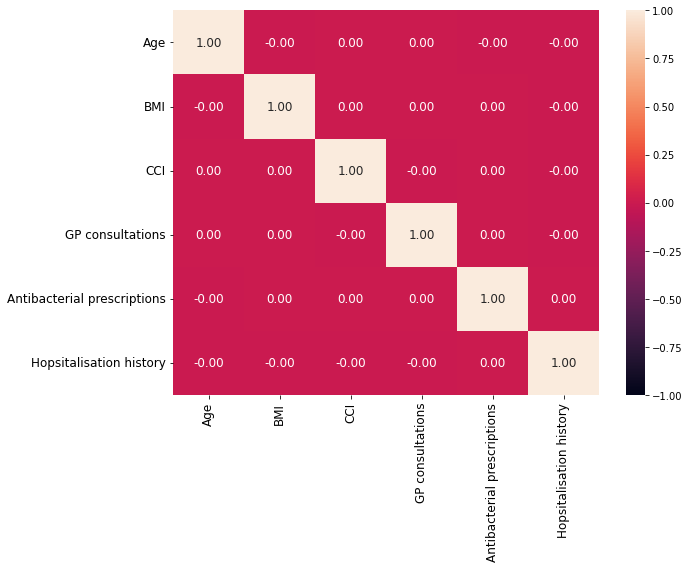

In [59]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data_sinusitis[['age', 'bmi', 'CCI', 'gp_count', 'antibacterial_brit', 'hx_hosp']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'GP consultations', 'Antibacterial prescriptions', 'Hopsitalisation history'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'GP consultations', 'Antibacterial prescriptions', 'Hopsitalisation history'], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_sinusitis/corr_sinusitis.jpg')
plt.show()

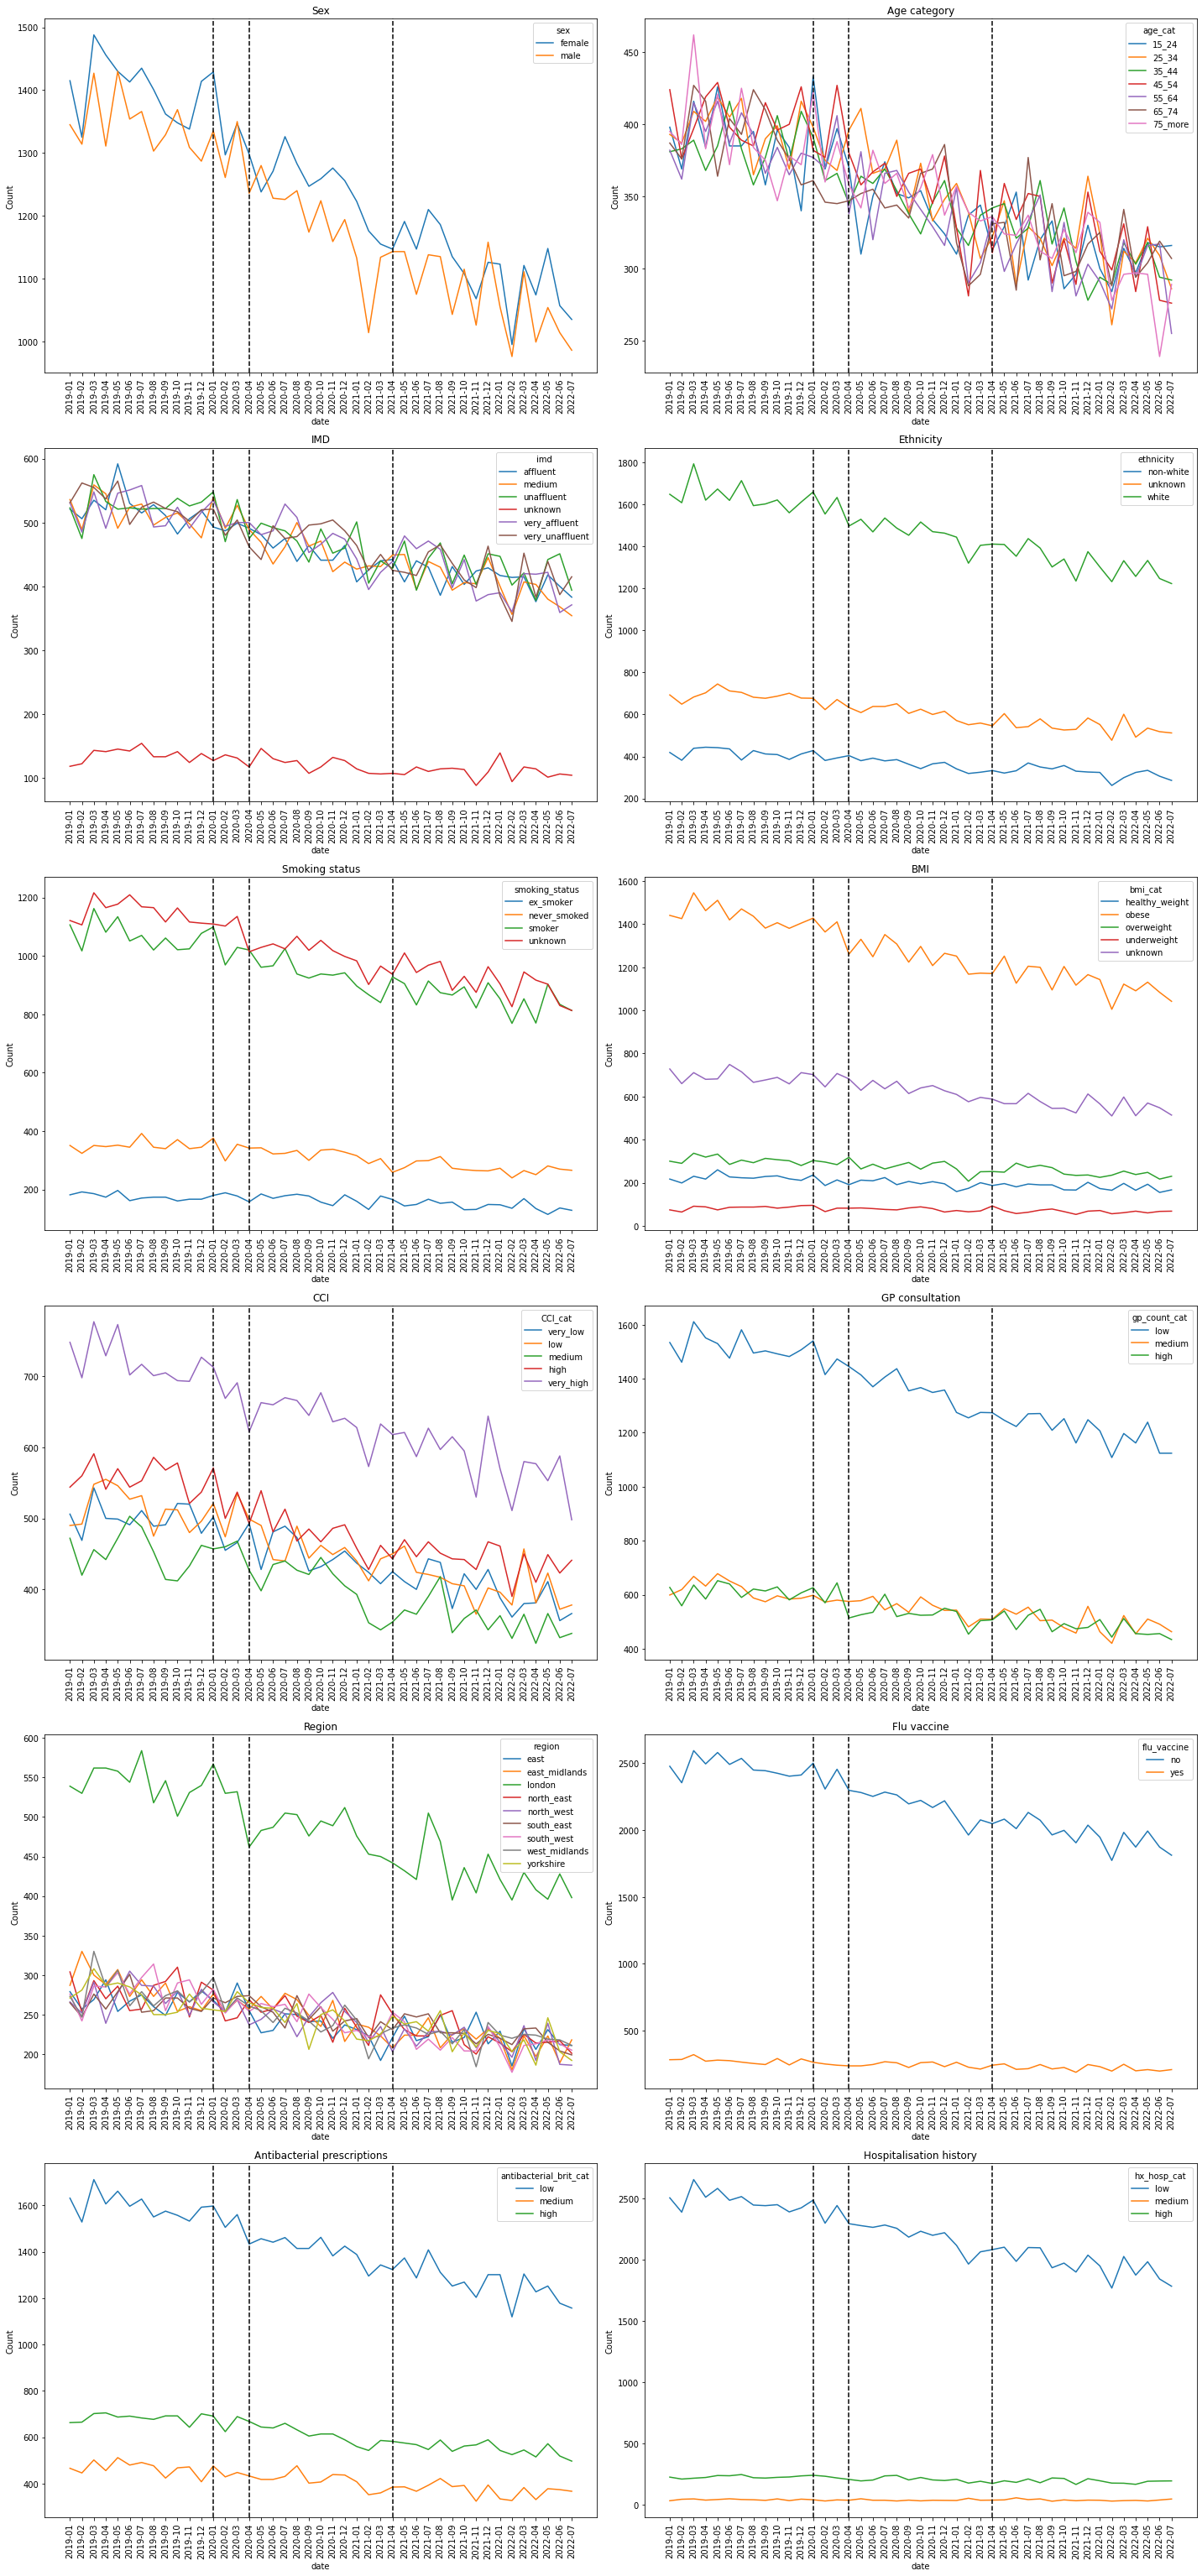

In [60]:
fig, axes = plt.subplots(6,2,
                        figsize=(20, 45)
                        )
create_lineplot(data_sinusitis, 'sex', 'Sex', axes[0,0])
create_lineplot(data_sinusitis, 'age_cat', 'Age category', axes[0,1])
create_lineplot(data_sinusitis, 'imd', 'IMD', axes[1,0])
create_lineplot(data_sinusitis, 'ethnicity', 'Ethnicity', axes[1,1])
create_lineplot(data_sinusitis, 'smoking_status', 'Smoking status', axes[2,0])
create_lineplot(data_sinusitis, 'bmi_cat', 'BMI', axes[2,1])
create_lineplot(data_sinusitis, 'CCI_cat', 'CCI', axes[3,0])
create_lineplot(data_sinusitis, 'gp_count_cat', 'GP consultation', axes[3,1])
create_lineplot(data_sinusitis, 'region', 'Region', axes[4,0])
create_lineplot(data_sinusitis, 'flu_vaccine', 'Flu vaccine', axes[4,1])
create_lineplot(data_sinusitis, 'antibacterial_brit_cat', 'Antibacterial prescriptions', axes[5,0])
# create_lineplot(data_sinusitis, 'meds_nonabs_cat', 'Medicines excpet antibacterials', axes[5,1])
create_lineplot(data_sinusitis, 'hx_hosp_cat', 'Hospitalisation history', axes[5,1])
# fig.delaxes(ax=axes[6,1])

# fig.suptitle('Risk Factors of sinusitis patients', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_sinusitis/risk_factors_cat_sinusitis.jpg')
plt.show()

## 4- Separate data of incident/prevalent and with/without antibiotics
We separate data of sinusitis to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [61]:
data_sinusitis = data_sinusitis[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 
                        'smoking_status', 'season', #'antibacterial_brit_cat', 'gp_count_cat', 'meds_nonabs_cat', 'hx_hosp_cat',
                        'antibacterial_brit', 'gp_count', #'meds_nonabs', 'hx_hosp',
                        'event_sinusitis_admitted', 'duration_sinusitis_admitted',
                        'sinusitis_ab_date', 'ab_type', 'incdt_sinusitis_date',
                        'date']]

data_sinusitis.shape

(105280, 18)

In [62]:
#incident and prevalent infection 
data_sinusitis_incdt = data_sinusitis[data_sinusitis['incdt_sinusitis_date'] == 0]
data_sinusitis_prevl = data_sinusitis[data_sinusitis['incdt_sinusitis_date'] == 1]
#switch variable sinusitis_ab_date into a binary variable
data_sinusitis_incdt[['sinusitis_ab_date']] = data_sinusitis_incdt[['sinusitis_ab_date']].where(data_sinusitis_incdt[['sinusitis_ab_date']].isnull(), 1).fillna(0).astype(int)
data_sinusitis_prevl[['sinusitis_ab_date']] = data_sinusitis_prevl[['sinusitis_ab_date']].where(data_sinusitis_prevl[['sinusitis_ab_date']].isnull(), 1).fillna(0).astype(int)

# no antibiotics and incident hospital admission
data_sinusitis_no_abs_incdt = data_sinusitis[data_sinusitis['sinusitis_ab_date'].isnull()] #gp_cons_sinusitis_ab
data_sinusitis_no_abs_incdt = data_sinusitis_no_abs_incdt[data_sinusitis_no_abs_incdt['incdt_sinusitis_date'] == 0]

# with antibiotics and incident hospital admission
data_sinusitis_abs_incdt = data_sinusitis[data_sinusitis['sinusitis_ab_date'].notnull()]
data_sinusitis_abs_incdt = data_sinusitis_abs_incdt[data_sinusitis_abs_incdt['incdt_sinusitis_date'] == 0]

# no antibiotics and prevalent hospital admission
data_sinusitis_no_abs_prevl = data_sinusitis[data_sinusitis['sinusitis_ab_date'].isnull()]
data_sinusitis_no_abs_prevl = data_sinusitis_no_abs_prevl[data_sinusitis_no_abs_prevl['incdt_sinusitis_date'] == 1]

# with antibiotics and prevalent hospital admission
data_sinusitis_abs_prevl = data_sinusitis[data_sinusitis['sinusitis_ab_date'].notnull()]
data_sinusitis_abs_prevl = data_sinusitis_abs_prevl[data_sinusitis_abs_prevl['incdt_sinusitis_date'] == 1]

print(f'shape of data_sinusitis_incdt: {data_sinusitis_incdt.shape}')
print(f'shape of data_sinusitis_prevl: {data_sinusitis_prevl.shape}')
print(f'shape of data_sinusitis_no_abs_incdt: {data_sinusitis_no_abs_incdt.shape}')
print(f'shape of data_sinusitis_abs_incdt: {data_sinusitis_abs_incdt.shape}')
print(f'shape of data_sinusitis_no_abs_prevl: {data_sinusitis_no_abs_prevl.shape}')
print(f'shape of data_sinusitis_abs_prevl: {data_sinusitis_abs_prevl.shape}')

shape of data_sinusitis_incdt: (94681, 18)
shape of data_sinusitis_prevl: (10599, 18)
shape of data_sinusitis_no_abs_incdt: (85163, 18)
shape of data_sinusitis_abs_incdt: (9518, 18)
shape of data_sinusitis_no_abs_prevl: (9508, 18)
shape of data_sinusitis_abs_prevl: (1091, 18)


In [63]:
#store data for plotting hosp admission counts and percentages
%store data_sinusitis
# save data
data_sinusitis.to_csv('../output/hospitalisation_prediction_sinusitis/data_sinusitis.csv')

Stored 'data_sinusitis' (DataFrame)


In [64]:
print(f'shape of data_sinusitis_no_abs_incdt: \n{data_sinusitis_no_abs_incdt.event_sinusitis_admitted.value_counts()}')
print(f'shape of data_sinusitis_abs_incdt: \n{data_sinusitis_abs_incdt.event_sinusitis_admitted.value_counts()}')
print(f'shape of data_sinusitis_no_abs_prevl: \n{data_sinusitis_no_abs_prevl.event_sinusitis_admitted.value_counts()}')
print(f'shape of data_sinusitis_abs_prevl: \n{data_sinusitis_abs_prevl.event_sinusitis_admitted.value_counts()}')

shape of data_sinusitis_no_abs_incdt: 
0.0    84525
1.0      638
Name: event_sinusitis_admitted, dtype: int64
shape of data_sinusitis_abs_incdt: 
0.0    9439
1.0      79
Name: event_sinusitis_admitted, dtype: int64
shape of data_sinusitis_no_abs_prevl: 
0.0    9436
1.0      72
Name: event_sinusitis_admitted, dtype: int64
shape of data_sinusitis_abs_prevl: 
0.0    1081
1.0      10
Name: event_sinusitis_admitted, dtype: int64


In [65]:
# # save data shape
# a = open("../output/hospitalisation_prediction_sinusitis/data_shape_cph_sinusitis.txt", "w")
# a.write("")
# a.writelines(['data_sinusitis_no_abs_incdt #observations, #events: %.0f' % (data_sinusitis_no_abs_incdt.event_sinusitis_admitted.value_counts()[0]), ', %.0f' % (data_sinusitis_no_abs_incdt.event_sinusitis_admitted.value_counts()[1]),
#               '\ndata_sinusitis_abs_incdt #observations, #events: %.0f' % (data_sinusitis_abs_incdt.event_sinusitis_admitted.value_counts()[0]), ', %.0f' % (data_sinusitis_abs_incdt.event_sinusitis_admitted.value_counts()[1]),
#               '\ndata_sinusitis_no_abs_prevl #observations, #events: %.0f' % (data_sinusitis_no_abs_prevl.event_sinusitis_admitted.value_counts()[0]), ', %.0f' % (data_sinusitis_no_abs_prevl.event_sinusitis_admitted.value_counts()[1]),
#               '\ndata_sinusitis_abs_prevl #observations, #events: %.0f' % (data_sinusitis_abs_prevl.event_sinusitis_admitted.value_counts()[0]), ', %.0f' % (data_sinusitis_abs_prevl.event_sinusitis_admitted.value_counts()[1])
#               ])

## 5- Cox modelling for hospital admissions
### 5-1- incident sinusitis with no antibiotics

<lifelines.CoxPHFitter: fitted with 63872 total observations, 63376 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 63872
number of events observed = 496
   partial log-likelihood = -5471.59
         time fit was run = 2022-11-02 10:40:20 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.04       1.04       0.15            -0.25             0.33                 0.78                 1.39
CCI_cat[T.medium]               -0.10       0.91       0.16            -0.40             0.21                 0.67                 1.23
CCI_cat[T.high]                  0.07       1.07       0.14            -0.22             0.35                 0.81                 1.41
CCI_cat[T.very_high]            -0.00       1.00       0.14            -0.27             0.26                 0.76                 1.30
age_cat[T.25_34]                 0.22       1.25       0.17            -0.12             0.56                 0.89                 1.75
age_cat[T.35_44]                 0.17       1.19       0.18            -0.18             0.52                 0.84                 1.68
age_cat[T.45_54]                 0.23       1.26       0.17            -0.11             0.57                 0.90                 1.77
age_cat[T.55_64]                 0.22       1.24       0.18            -0.13             0.56                 0.88                 1.75
age_cat[T.65_74]                 0.19       1.21       0.18            -0.15             0.54                 0.86                 1.71
age_cat[T.75_more]               0.22       1.25       0.17            -0.12             0.57                 0.89                 1.76
antibacterial_brit               0.04       1.04       0.03            -0.02             0.10                 0.98                 1.11
bmi_cat[T.obese]                 0.28       1.32       0.19            -0.10             0.65                 0.90                 1.93
bmi_cat[T.overweight]            0.34       1.41       0.22            -0.10             0.78                 0.90                 2.18
bmi_cat[T.underweight]           0.37       1.45       0.31            -0.24             0.98                 0.79                 2.65
bmi_cat[T.unknown]               0.39       1.47       0.20            -0.01             0.78                 0.99                 2.19
ethnicity[T.unknown]            -0.09       0.91       0.14            -0.36             0.19                 0.69                 1.20
ethnicity[T.white]              -0.17       0.84       0.12            -0.42             0.07                 0.66                 1.07
flu_vaccine[T.yes]              -0.10       0.91       0.15            -0.40             0.21                 0.67                 1.23
imd[T.medium]                    0.14       1.15       0.15            -0.15             0.43                 0.86                 1.53
imd[T.unaffluent]                0.15       1.17       0.15            -0.13             0.44                 0.87                 1.55
imd[T.unknown]                   0.27       1.31       0.21            -0.15             0.69                 0.86                 1.99
imd[T.very_affluent]             0.04       1.04       0.15            -0.26             0.33                 0.77                 1.39
imd[T.very_unaffluent]           0.06       1.07       0.15            -0.23             0.36                 0.79                 1.43
region[T.east_midlands]         -0.28       0.76       0.20            -0.66             0.11                 0.52                 1.11
region[T.london]                -0.17       0.84       0.1

12771


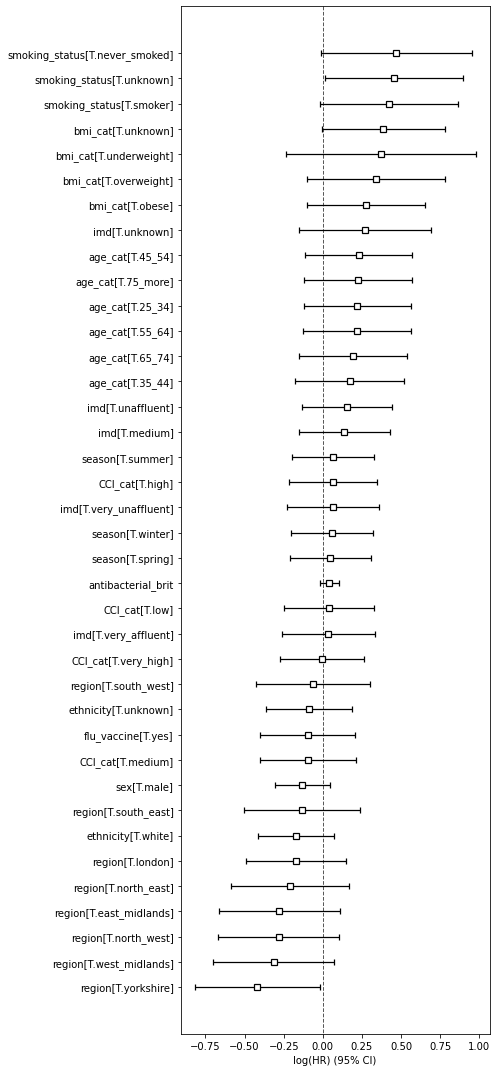

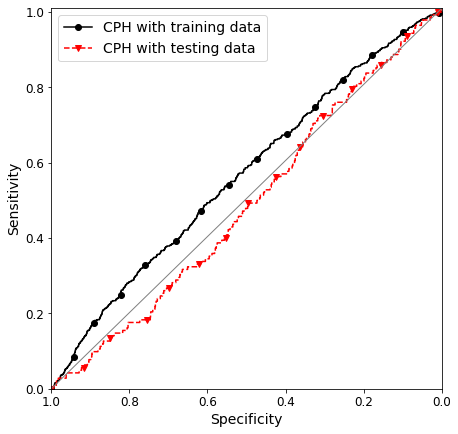

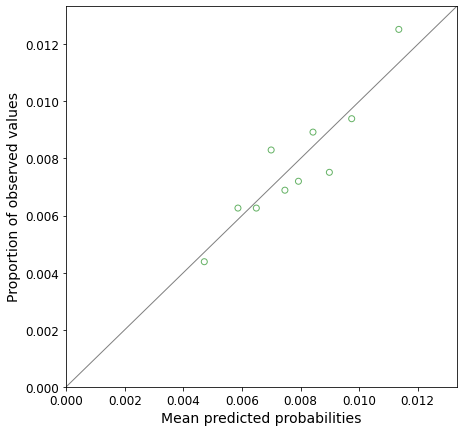

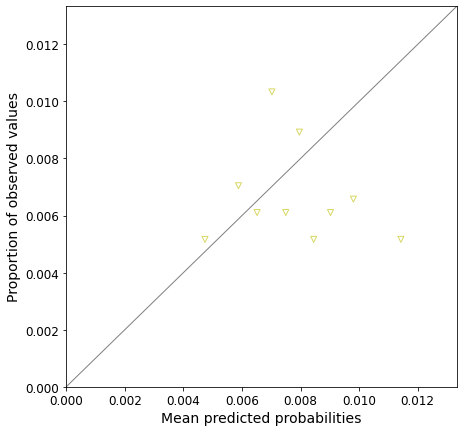

In [66]:
#data prep
data, data_sinusitis_no_abs_incdt_enc = cox_data_prep(data_sinusitis_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

#make summary table
make_summary_table('sinusitis', 'no_abs_incdt', data_sinusitis_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('sinusitis', 'no_abs_incdt', data_sinusitis_no_abs_incdt)

#build cox model 
cph_sinusitis_no_abs_incdt, data_sinusitis_no_abs_incdt_train, data_sinusitis_no_abs_incdt_test = cox_model_build('sinusitis', 'no_abs_incdt', data_sinusitis_no_abs_incdt)

#calculate and save betas and sum of betas 
betas_sumbetas_calculate(cph_sinusitis_no_abs_incdt, '../output/hospitalisation_prediction_sinusitis/', 'betas_cph_sinusitis_no_abs_incdt.csv', data_sinusitis_no_abs_incdt_enc, data_sinusitis_no_abs_incdt, 'sum_betas_cph_sinusitis_no_abs_incdt.csv')

#plot roc curve
cph_roc_curve(cph_sinusitis_no_abs_incdt, 'event_sinusitis_admitted', data_sinusitis_no_abs_incdt_train, data_sinusitis_no_abs_incdt_test, '../output/hospitalisation_prediction_sinusitis', 'roc_cph_sinusitis_no_abs_incdt.jpg')

#plot calibration plots with development and validation data
cph_calibration(cph_sinusitis_no_abs_incdt, data_sinusitis_no_abs_incdt_train, 'event_sinusitis_admitted', data_sinusitis_no_abs_incdt_test, '../output/hospitalisation_prediction_sinusitis/', 'calibration_cph_sinusitis_no_abs_incdt_train.jpg', 'calibration_cph_sinusitis_no_abs_incdt_test.jpg')

# calculate c-statistics
cph_output(cph_sinusitis_no_abs_incdt, 'sinusitis', 'no_abs_incdt', data_sinusitis_no_abs_incdt_train, data_sinusitis_no_abs_incdt_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')

### 5-2- incident sinusitis with antibiotics

<lifelines.CoxPHFitter: fitted with 7138 total observations, 7079 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 7138
number of events observed = 59
   partial log-likelihood = -508.75
         time fit was run = 2022-11-02 10:40:34 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.54       1.72       0.44            -0.33             1.41                 0.72                 4.12
CCI_cat[T.medium]                0.43       1.53       0.47            -0.49             1.34                 0.61                 3.82
CCI_cat[T.high]                  0.13       1.14       0.48            -0.80             1.06                 0.45                 2.90
CCI_cat[T.very_high]             0.36       1.43       0.43            -0.49             1.21                 0.61                 3.34
age_cat[T.25_34]                 0.60       1.82       0.50            -0.39             1.58                 0.68                 4.86
age_cat[T.35_44]                 0.41       1.50       0.53            -0.63             1.45                 0.53                 4.25
age_cat[T.45_54]                 0.26       1.30       0.54            -0.80             1.32                 0.45                 3.76
age_cat[T.55_64]                 0.26       1.29       0.54            -0.81             1.32                 0.45                 3.75
age_cat[T.65_74]                 0.44       1.55       0.53            -0.60             1.48                 0.55                 4.37
age_cat[T.75_more]               0.14       1.15       0.56            -0.96             1.23                 0.38                 3.43
antibacterial_brit              -0.05       0.95       0.09            -0.23             0.13                 0.79                 1.14
bmi_cat[T.obese]                -0.20       0.82       0.45            -1.08             0.68                 0.34                 1.97
bmi_cat[T.overweight]            0.03       1.03       0.53            -1.00             1.07                 0.37                 2.92
bmi_cat[T.underweight]           0.43       1.53       0.65            -0.84             1.70                 0.43                 5.47
bmi_cat[T.unknown]              -0.75       0.47       0.53            -1.78             0.29                 0.17                 1.34
ethnicity[T.unknown]             0.03       1.03       0.44            -0.83             0.89                 0.43                 2.44
ethnicity[T.white]               0.09       1.09       0.39            -0.69             0.86                 0.50                 2.35
flu_vaccine[T.yes]               0.87       2.39       0.33             0.23             1.51                 1.26                 4.54
imd[T.medium]                    0.31       1.37       0.42            -0.50             1.13                 0.61                 3.09
imd[T.unaffluent]               -0.40       0.67       0.49            -1.37             0.57                 0.26                 1.77
imd[T.unknown]                   0.37       1.45       0.59            -0.79             1.54                 0.45                 4.65
imd[T.very_affluent]             0.34       1.41       0.41            -0.46             1.15                 0.63                 3.15
imd[T.very_unaffluent]          -0.22       0.80       0.46            -1.12             0.68                 0.33                 1.98
region[T.east_midlands]         -0.61       0.55       0.73            -2.04             0.83                 0.13                 2.29
region[T.london]                 0.23       1.26       0.53    

12764


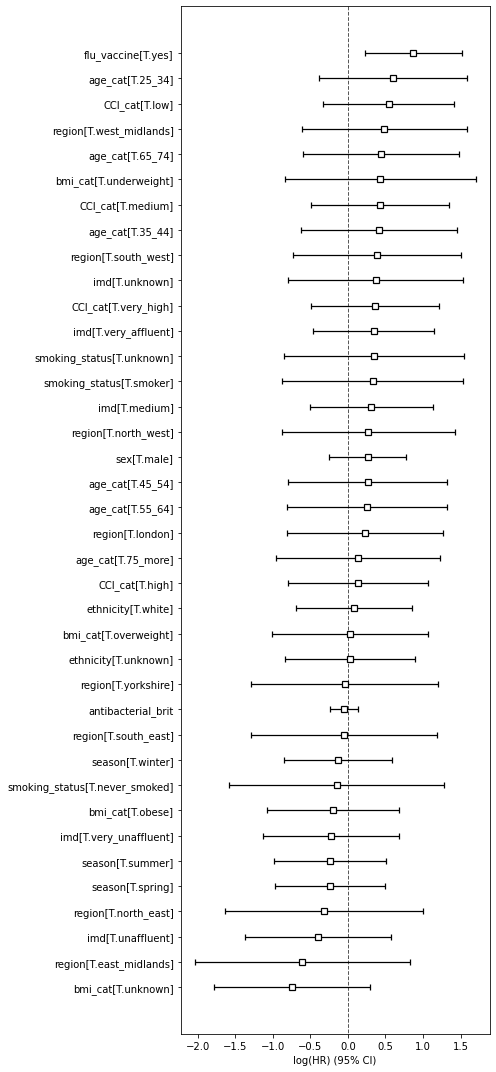

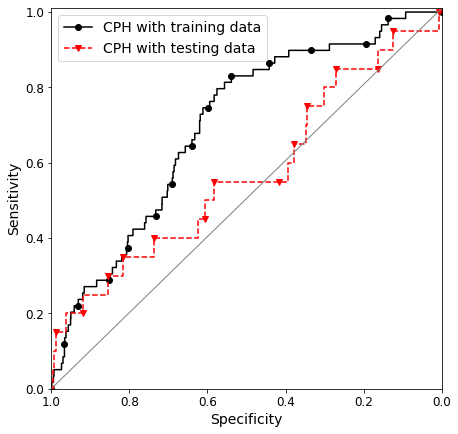

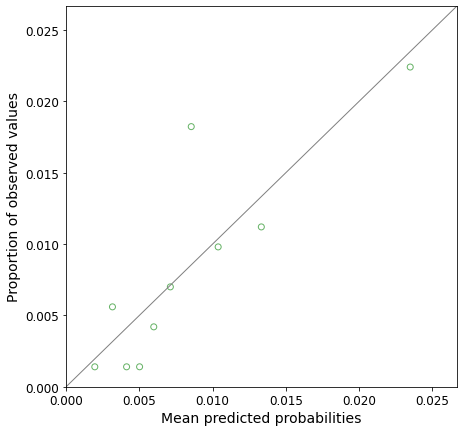

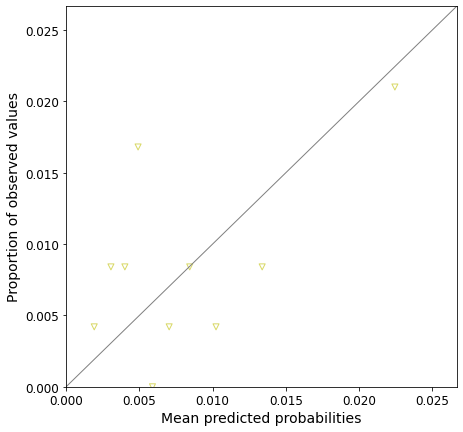

In [67]:
#data prep
data, data_sinusitis_abs_incdt_enc = cox_data_prep(data_sinusitis_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

#make summary table
make_summary_table('sinusitis', 'abs_incdt', data_sinusitis_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('sinusitis', 'abs_incdt', data_sinusitis_abs_incdt)

#build cox model 
cph_sinusitis_abs_incdt, data_sinusitis_abs_incdt_train, data_sinusitis_abs_incdt_test = cox_model_build('sinusitis', 'abs_incdt', data_sinusitis_abs_incdt)

#calculate and save betas and sum of betas 
betas_sumbetas_calculate(cph_sinusitis_abs_incdt, '../output/hospitalisation_prediction_sinusitis/', 'betas_cph_sinusitis_abs_incdt.csv', data_sinusitis_abs_incdt_enc, data_sinusitis_abs_incdt, 'sum_betas_cph_sinusitis_abs_incdt.csv')

#plot roc curve
cph_roc_curve(cph_sinusitis_abs_incdt, 'event_sinusitis_admitted', data_sinusitis_abs_incdt_train, data_sinusitis_abs_incdt_test, '../output/hospitalisation_prediction_sinusitis', 'roc_cph_sinusitis_abs_incdt.jpg')

#plot calibration plots with development and validation data
cph_calibration(cph_sinusitis_abs_incdt, data_sinusitis_abs_incdt_train, 'event_sinusitis_admitted', data_sinusitis_abs_incdt_test, '../output/hospitalisation_prediction_sinusitis/', 'calibration_cph_sinusitis_abs_incdt_train.jpg', 'calibration_cph_sinusitis_abs_incdt_test.jpg')

# calculate c-statistics
cph_output(cph_sinusitis_abs_incdt, 'sinusitis', 'abs_incdt', data_sinusitis_abs_incdt_train, data_sinusitis_abs_incdt_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')

### 5-3- prevalent sinusitis with no antibiotics

<lifelines.CoxPHFitter: fitted with 7131 total observations, 7081 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 7131
number of events observed = 50
   partial log-likelihood = -424.24
         time fit was run = 2022-11-02 10:40:42 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.40       1.50       0.46            -0.50             1.30                 0.61                 3.69
CCI_cat[T.medium]               -0.21       0.81       0.54            -1.28             0.85                 0.28                 2.34
CCI_cat[T.high]                 -0.59       0.55       0.57            -1.71             0.53                 0.18                 1.70
CCI_cat[T.very_high]             0.40       1.49       0.42            -0.43             1.23                 0.65                 3.42
age_cat[T.25_34]                -0.16       0.85       0.56            -1.25             0.93                 0.29                 2.54
age_cat[T.35_44]                -0.67       0.51       0.63            -1.90             0.57                 0.15                 1.76
age_cat[T.45_54]                 0.07       1.07       0.52            -0.95             1.08                 0.39                 2.95
age_cat[T.55_64]                -0.02       0.98       0.54            -1.07             1.03                 0.34                 2.80
age_cat[T.65_74]                 0.57       1.76       0.47            -0.36             1.49                 0.70                 4.42
age_cat[T.75_more]              -0.42       0.66       0.59            -1.57             0.73                 0.21                 2.08
antibacterial_brit              -0.02       0.98       0.10            -0.22             0.18                 0.80                 1.19
bmi_cat[T.obese]                 0.24       1.27       0.62            -0.97             1.45                 0.38                 4.25
bmi_cat[T.overweight]            0.42       1.52       0.71            -0.97             1.81                 0.38                 6.09
bmi_cat[T.underweight]           0.72       2.06       0.92            -1.08             2.52                 0.34                12.43
bmi_cat[T.unknown]               0.54       1.72       0.63            -0.70             1.78                 0.50                 5.91
ethnicity[T.unknown]             0.04       1.04       0.44            -0.82             0.90                 0.44                 2.47
ethnicity[T.white]              -0.25       0.78       0.41            -1.05             0.54                 0.35                 1.72
flu_vaccine[T.yes]              -0.92       0.40       0.72            -2.34             0.49                 0.10                 1.64
imd[T.medium]                    0.69       1.99       0.51            -0.31             1.69                 0.73                 5.40
imd[T.unaffluent]                0.20       1.22       0.56            -0.89             1.30                 0.41                 3.66
imd[T.unknown]                  -0.25       0.77       1.08            -2.38             1.87                 0.09                 6.46
imd[T.very_affluent]             0.79       2.20       0.50            -0.18             1.76                 0.83                 5.81
imd[T.very_unaffluent]           0.73       2.07       0.50            -0.26             1.71                 0.77                 5.53
region[T.east_midlands]         -0.74       0.48       0.56            -1.83             0.36                 0.16                 1.44
region[T.london]                -0.78       0.46       0.47    

12784


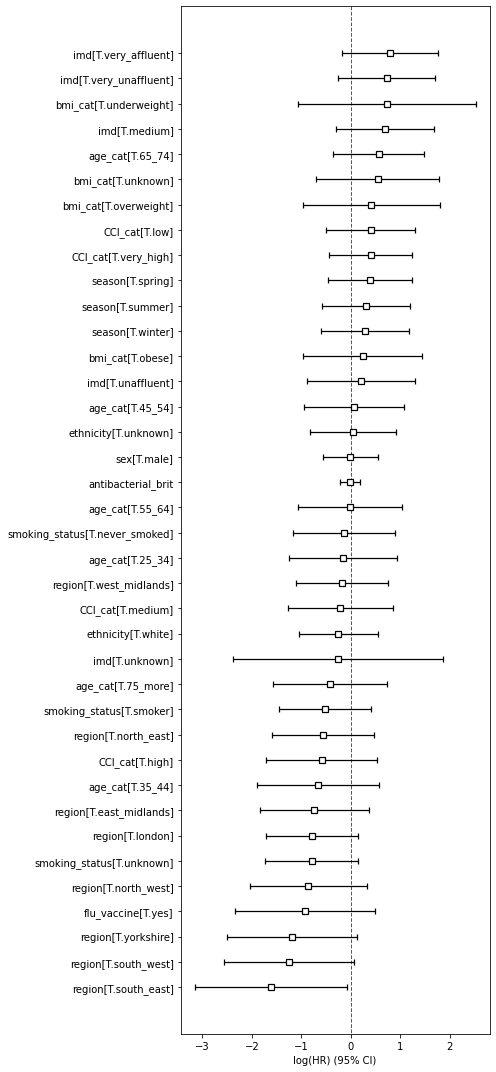

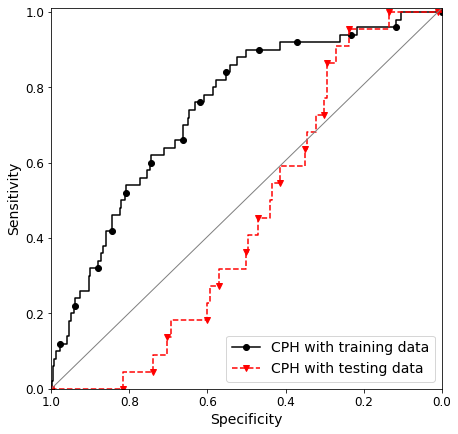

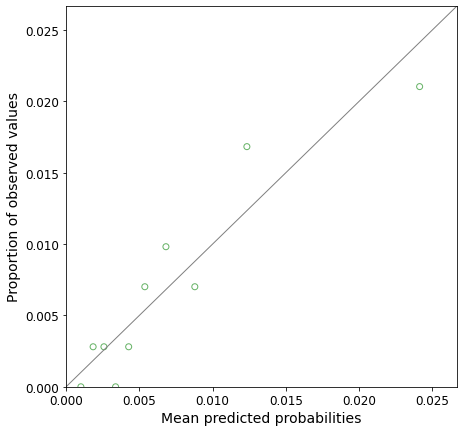

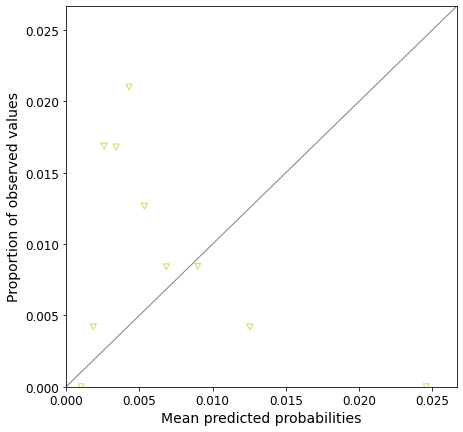

In [68]:
#data prep
data, data_sinusitis_no_abs_prevl_enc = cox_data_prep(data_sinusitis_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

#make summary table
make_summary_table('sinusitis', 'no_abs_prevl', data_sinusitis_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('sinusitis', 'no_abs_prevl', data_sinusitis_no_abs_prevl)

#build cox model 
cph_sinusitis_no_abs_prevl, data_sinusitis_no_abs_prevl_train, data_sinusitis_no_abs_prevl_test = cox_model_build('sinusitis', 'no_abs_prevl', data_sinusitis_no_abs_prevl)

#calculate and save betas and sum of betas 
betas_sumbetas_calculate(cph_sinusitis_no_abs_prevl, '../output/hospitalisation_prediction_sinusitis/', 'betas_cph_sinusitis_no_abs_prevl.csv', data_sinusitis_no_abs_prevl_enc, data_sinusitis_no_abs_prevl, 'sum_betas_cph_sinusitis_no_abs_prevl.csv')

#plot roc curve
cph_roc_curve(cph_sinusitis_no_abs_prevl, 'event_sinusitis_admitted', data_sinusitis_no_abs_prevl_train, data_sinusitis_no_abs_prevl_test, '../output/hospitalisation_prediction_sinusitis', 'roc_cph_sinusitis_no_abs_prevl.jpg')

#plot calibration plots with development and validation data
cph_calibration(cph_sinusitis_no_abs_prevl, data_sinusitis_no_abs_prevl_train, 'event_sinusitis_admitted', data_sinusitis_no_abs_prevl_test, '../output/hospitalisation_prediction_sinusitis/', 'calibration_cph_sinusitis_no_abs_prevl_train.jpg', 'calibration_cph_sinusitis_no_abs_prevl_test.jpg')

# calculate c-statistics
cph_output(cph_sinusitis_no_abs_prevl, 'sinusitis', 'no_abs_prevl', data_sinusitis_no_abs_prevl_train, data_sinusitis_no_abs_prevl_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')

### 5-4- prevalent sinusitis with antibiotics

In [69]:
#data prep
data, data_sinusitis_abs_prevl_enc = cox_data_prep(data_sinusitis_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

#make summary table
make_summary_table('sinusitis', 'abs_prevl', data_sinusitis_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('sinusitis', 'abs_prevl', data_sinusitis_abs_prevl)

# #build cox model 
# cph_sinusitis_abs_prevl, data_sinusitis_abs_prevl_train, data_sinusitis_abs_prevl_test = cox_model_build('sinusitis', 'abs_prevl', data_sinusitis_abs_prevl)

# #calculate and save betas and sum of betas 
# betas_sumbetas_calculate(cph_sinusitis_abs_prevl, '../output/hospitalisation_prediction_sinusitis/', 'betas_cph_sinusitis_abs_prevl.csv', data_sinusitis_abs_prevl_enc, data_sinusitis_abs_prevl, 'sum_betas_cph_sinusitis_abs_prevl.csv')

# #plot roc curve
# cph_roc_curve(cph_sinusitis_abs_prevl, 'event_sinusitis_admitted', data_sinusitis_abs_prevl_train, data_sinusitis_abs_prevl_test, '../output/hospitalisation_prediction_sinusitis', 'roc_cph_sinusitis_abs_prevl.jpg')

# #plot calibration plots with development and validation data
# cph_calibration(cph_sinusitis_abs_prevl, data_sinusitis_abs_prevl_train, 'event_sinusitis_admitted', data_sinusitis_abs_prevl_test, '../output/hospitalisation_prediction_sinusitis/', 'calibration_cph_sinusitis_abs_prevl_train.jpg', 'calibration_cph_sinusitis_abs_prevl_test.jpg')

# # calculate c-statistics
# cph_output(cph_sinusitis_abs_prevl, 'sinusitis', 'abs_prevl', data_sinusitis_abs_prevl_train, data_sinusitis_abs_prevl_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')

### 5-5- incident sinusitis

<lifelines.CoxPHFitter: fitted with 71010 total observations, 70466 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 71010
number of events observed = 544
   partial log-likelihood = -6056.93
         time fit was run = 2022-11-02 10:40:49 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.06       0.94       0.14            -0.33             0.21                 0.72                 1.24
CCI_cat[T.medium]               -0.20       0.82       0.15            -0.49             0.09                 0.62                 1.10
CCI_cat[T.high]                 -0.04       0.96       0.13            -0.31             0.22                 0.74                 1.25
CCI_cat[T.very_high]            -0.11       0.90       0.13            -0.36             0.15                 0.70                 1.16
age_cat[T.25_34]                 0.29       1.34       0.18            -0.05             0.64                 0.95                 1.89
age_cat[T.35_44]                 0.41       1.51       0.17             0.07             0.75                 1.08                 2.12
age_cat[T.45_54]                 0.42       1.52       0.17             0.08             0.75                 1.09                 2.13
age_cat[T.55_64]                 0.39       1.48       0.17             0.05             0.73                 1.05                 2.07
age_cat[T.65_74]                 0.40       1.49       0.17             0.06             0.73                 1.06                 2.08
age_cat[T.75_more]               0.32       1.37       0.18            -0.03             0.66                 0.97                 1.94
antibacterial_brit               0.02       1.02       0.03            -0.04             0.08                 0.96                 1.08
bmi_cat[T.obese]                 0.14       1.15       0.17            -0.19             0.48                 0.82                 1.61
bmi_cat[T.overweight]            0.30       1.35       0.20            -0.09             0.69                 0.92                 2.00
bmi_cat[T.underweight]           0.22       1.25       0.29            -0.34             0.78                 0.71                 2.18
bmi_cat[T.unknown]               0.08       1.08       0.18            -0.28             0.44                 0.76                 1.55
ethnicity[T.unknown]             0.08       1.08       0.14            -0.18             0.35                 0.83                 1.41
ethnicity[T.white]              -0.10       0.91       0.12            -0.34             0.14                 0.71                 1.15
flu_vaccine[T.yes]               0.13       1.13       0.14            -0.14             0.39                 0.87                 1.48
imd[T.medium]                    0.10       1.10       0.14            -0.18             0.37                 0.84                 1.45
imd[T.unaffluent]                0.11       1.11       0.14            -0.17             0.38                 0.85                 1.46
imd[T.unknown]                   0.26       1.30       0.20            -0.13             0.65                 0.88                 1.92
imd[T.very_affluent]            -0.05       0.95       0.14            -0.33             0.23                 0.72                 1.26
imd[T.very_unaffluent]          -0.03       0.97       0.14            -0.32             0.25                 0.73                 1.28
region[T.east_midlands]         -0.33       0.72       0.19            -0.70             0.04                 0.50                 1.04
region[T.london]                -0.12       0.89       0.1

13044


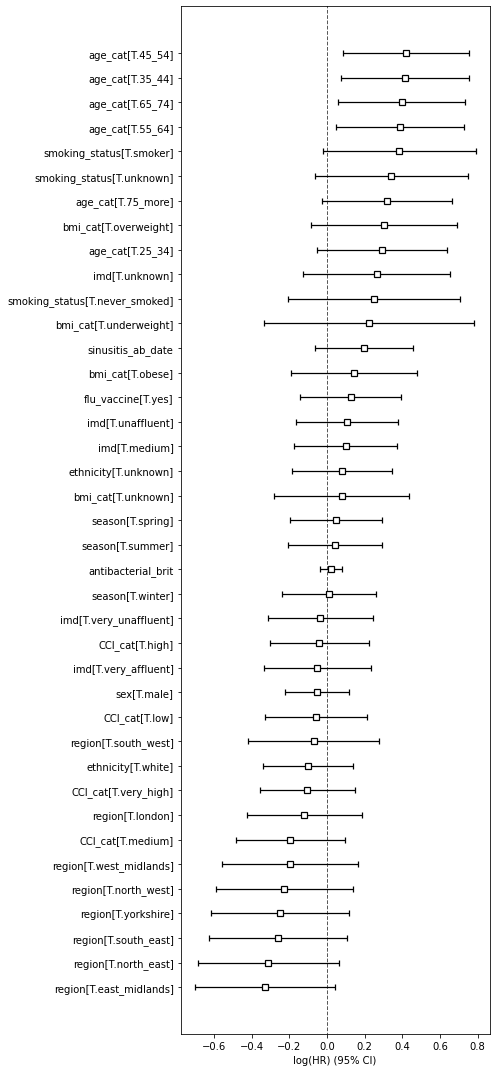

In [70]:
#data prep
data, data_sinusitis_incdt_enc = cox_data_prep(data_sinusitis_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

#make summary tables from preped data
make_summary_table('sinusitis', 'incdt', data_sinusitis_incdt_enc)
make_summary_table_hosped('sinusitis', 'incdt', data_sinusitis_incdt)

cph_sinusitis_incdt, data_sinusitis_incdt_train, data_sinusitis_incdt_test = cox_model_abs_build('sinusitis', 'incdt', data_sinusitis_incdt)

# #calculate and save betas and sum of betas 
# betas_sumbetas_calculate(cph_sinusitis_incdt, '../output/hospitalisation_prediction_sinusitis/', 'betas_cph_sinusitis_incdt.csv', data_sinusitis_incdt_enc, data_sinusitis_incdt, 'sum_betas_cph_sinusitis_incdt.csv')

# #plot roc curve
# cph_roc_curve(cph_sinusitis_incdt, 'event_sinusitis_admitted', data_sinusitis_incdt_train, data_sinusitis_incdt_test, '../output/hospitalisation_prediction_sinusitis', 'roc_cph_sinusitis_incdt.jpg')

# # plot calibration plots with development and validation data
# cph_calibration(cph_sinusitis_incdt, data_sinusitis_incdt_train, 'event_sinusitis_admitted', data_sinusitis_incdt_test, '../output/hospitalisation_prediction_sinusitis/', 'calibration_cph_sinusitis_incdt_train.jpg', 'calibration_cph_sinusitis_incdt_test.jpg')

# calculate c-statistics
cph_output(cph_sinusitis_incdt, 'sinusitis', 'incdt', data_sinusitis_incdt_train, data_sinusitis_incdt_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')

### 5-6- prevalent sinusitis

<lifelines.CoxPHFitter: fitted with 7949 total observations, 7886 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 7949
number of events observed = 63
   partial log-likelihood = -549.79
         time fit was run = 2022-11-02 10:40:56 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.27       1.32       0.37            -0.45             1.00                 0.64                 2.71
CCI_cat[T.medium]               -0.51       0.60       0.47            -1.44             0.41                 0.24                 1.50
CCI_cat[T.high]                 -0.57       0.56       0.45            -1.46             0.31                 0.23                 1.37
CCI_cat[T.very_high]            -0.03       0.97       0.37            -0.75             0.68                 0.47                 1.98
age_cat[T.25_34]                -0.10       0.90       0.46            -1.01             0.80                 0.36                 2.22
age_cat[T.35_44]                -0.56       0.57       0.52            -1.57             0.45                 0.21                 1.58
age_cat[T.45_54]                -0.19       0.82       0.46            -1.10             0.71                 0.33                 2.03
age_cat[T.55_64]                -0.14       0.87       0.46            -1.04             0.77                 0.35                 2.15
age_cat[T.65_74]                 0.31       1.36       0.42            -0.50             1.12                 0.60                 3.08
age_cat[T.75_more]              -0.64       0.53       0.52            -1.66             0.37                 0.19                 1.45
antibacterial_brit               0.03       1.03       0.09            -0.15             0.20                 0.86                 1.22
bmi_cat[T.obese]                 0.06       1.06       0.48            -0.89             1.01                 0.41                 2.75
bmi_cat[T.overweight]            0.08       1.08       0.59            -1.08             1.23                 0.34                 3.42
bmi_cat[T.underweight]           0.09       1.09       0.84            -1.56             1.74                 0.21                 5.67
bmi_cat[T.unknown]               0.18       1.20       0.51            -0.82             1.17                 0.44                 3.23
ethnicity[T.unknown]            -0.28       0.75       0.42            -1.10             0.53                 0.33                 1.71
ethnicity[T.white]              -0.11       0.89       0.36            -0.81             0.58                 0.44                 1.79
flu_vaccine[T.yes]              -0.40       0.67       0.52            -1.42             0.61                 0.24                 1.85
imd[T.medium]                    0.16       1.18       0.44            -0.70             1.02                 0.50                 2.77
imd[T.unaffluent]                0.53       1.69       0.40            -0.27             1.32                 0.77                 3.75
imd[T.unknown]                   0.24       1.28       0.66            -1.05             1.54                 0.35                 4.66
imd[T.very_affluent]             0.13       1.14       0.43            -0.71             0.98                 0.49                 2.65
imd[T.very_unaffluent]           0.14       1.15       0.44            -0.72             1.00                 0.49                 2.72
region[T.east_midlands]         -0.73       0.48       0.51            -1.73             0.26                 0.18                 1.30
region[T.london]                -0.53       0.59       0.40    

13067


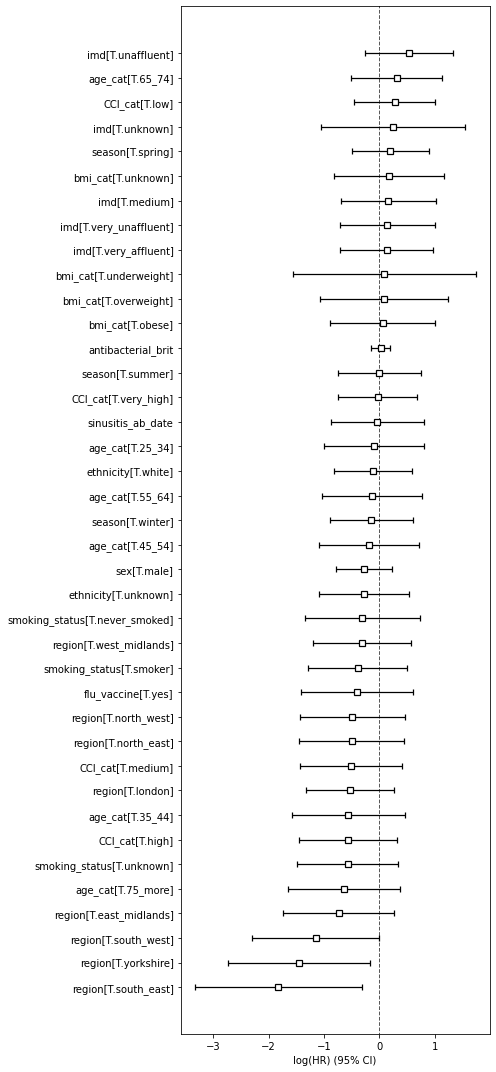

In [71]:
#data prep
data, data_sinusitis_prevl_enc = cox_data_prep(data_sinusitis_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

#make summary tables from preped data
make_summary_table('sinusitis', 'prevl', data_sinusitis_prevl_enc)
make_summary_table_hosped('sinusitis', 'prevl', data_sinusitis_prevl)

cph_sinusitis_prevl, data_sinusitis_prevl_train, data_sinusitis_prevl_test = cox_model_abs_build('sinusitis', 'prevl', data_sinusitis_prevl)

# #calculate and save betas and sum of betas 
# betas_sumbetas_calculate(cph_sinusitis_prevl, '../output/hospitalisation_prediction_sinusitis/', 'betas_cph_sinusitis_prevl.csv', data_sinusitis_prevl_enc, data_sinusitis_prevl, 'sum_betas_cph_sinusitis_prevl.csv')

# #plot roc curve
# cph_roc_curve(cph_sinusitis_prevl, 'event_sinusitis_admitted', data_sinusitis_prevl_train, data_sinusitis_prevl_test, '../output/hospitalisation_prediction_sinusitis', 'roc_cph_sinusitis_prevl.jpg')

# # plot calibration plots with development and validation data
# cph_calibration(cph_sinusitis_prevl, data_sinusitis_prevl_train, 'event_sinusitis_admitted', data_sinusitis_prevl_test, '../output/hospitalisation_prediction_sinusitis/', 'calibration_cph_sinusitis_prevl_train.jpg', 'calibration_cph_sinusitis_prevl_test.jpg')

# calculate c-statistics
cph_output(cph_sinusitis_prevl, 'sinusitis', 'prevl', data_sinusitis_prevl_train, data_sinusitis_prevl_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')

## 6- Logistic regression for hospital admission
### 6-1- incident sinusitis with no antibiotics

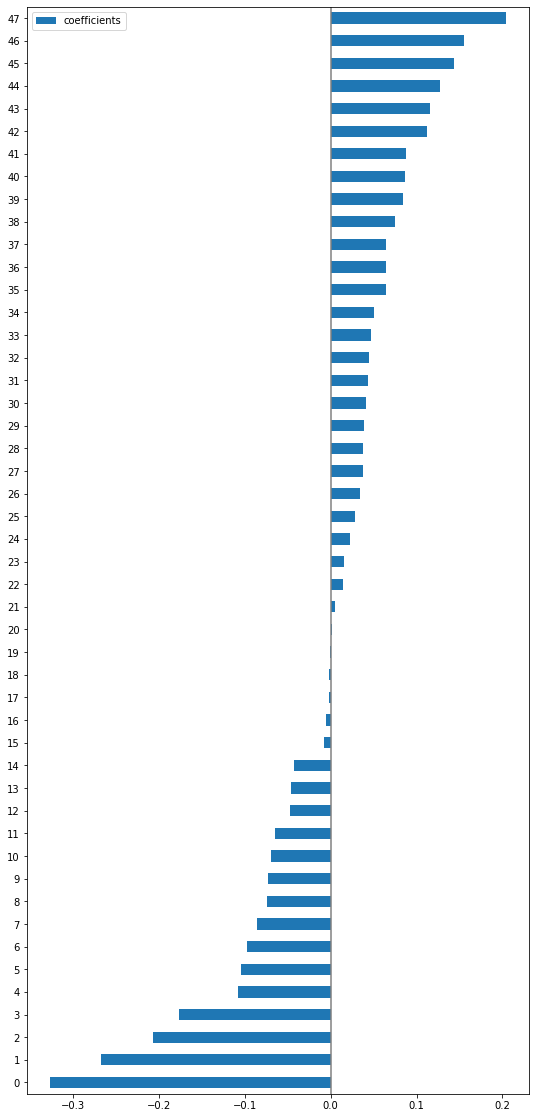

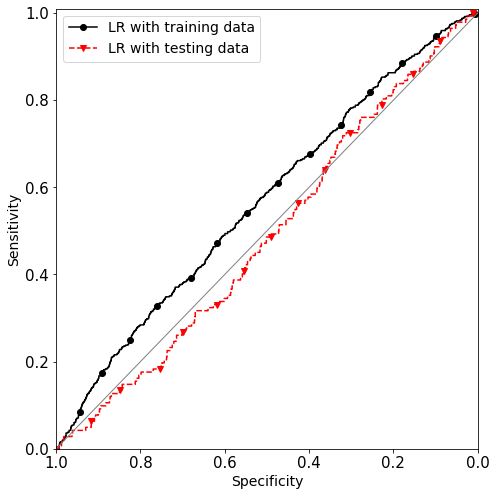

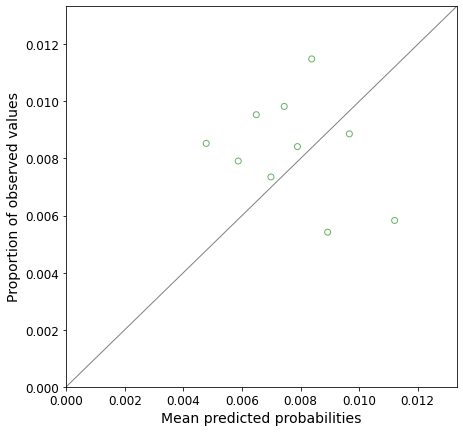

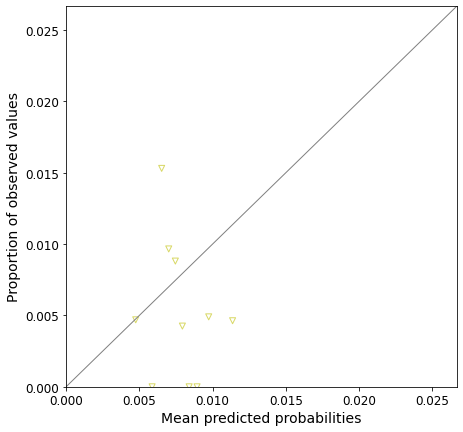

In [72]:
#data prep for lr
data, data_sinusitis_no_abs_incdt_enc = cox_data_prep(data_sinusitis_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

#build lr model
lr_sinusitis_no_abs_incdt, data_sinusitis_no_abs_incdt_lr_y_train, pred_proba_sinusitis_no_abs_incdt_train, data_sinusitis_no_abs_incdt_lr_y_test, pred_proba_sinusitis_no_abs_incdt_test = lr_model_build('sinusitis', 'no_abs_incdt', data_sinusitis_no_abs_incdt, data_sinusitis_no_abs_incdt_enc)

#save betas of lr model
lr_betas(lr_sinusitis_no_abs_incdt, 'sinusitis', 'no_abs_incdt')

#plot roc curev of lr model
lr_roc_curve('sinusitis', 'no_abs_incdt', data_sinusitis_no_abs_incdt_lr_y_train, pred_proba_sinusitis_no_abs_incdt_train, data_sinusitis_no_abs_incdt_lr_y_test, pred_proba_sinusitis_no_abs_incdt_test)

#plot calibration of lr model
lr_pred_calib('sinusitis', 'no_abs_incdt', data_sinusitis_no_abs_incdt_train, pred_proba_sinusitis_no_abs_incdt_train, data_sinusitis_no_abs_incdt_test, pred_proba_sinusitis_no_abs_incdt_test)

#save auroc and brier of lr model
lr_auroc_brier('sinusitis', 'no_abs_incdt', data_sinusitis_no_abs_incdt_lr_y_train, pred_proba_sinusitis_no_abs_incdt_train, data_sinusitis_no_abs_incdt_lr_y_test, pred_proba_sinusitis_no_abs_incdt_test)

### 6-2- incident sinusitis with antibiotics

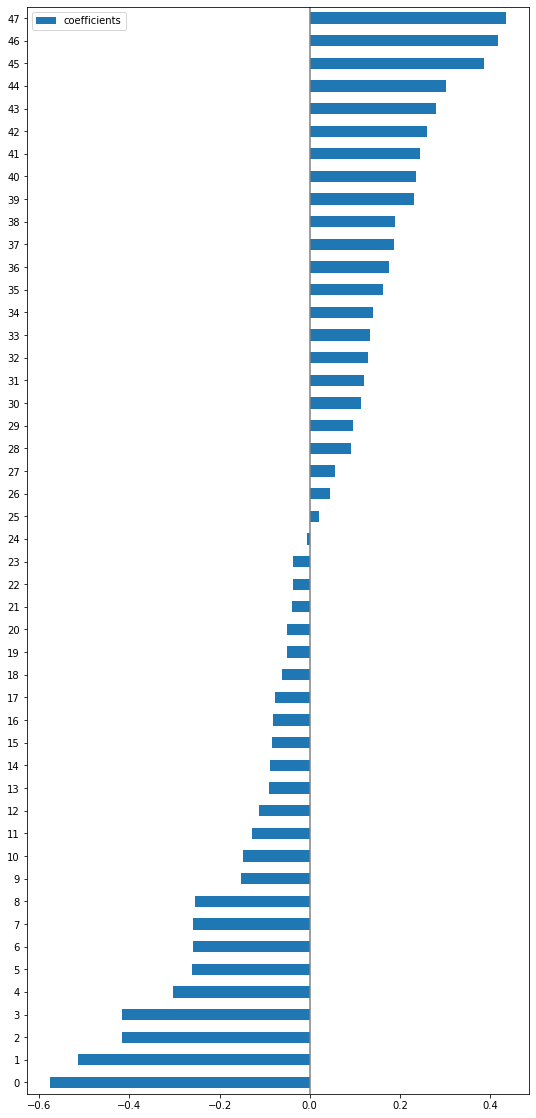

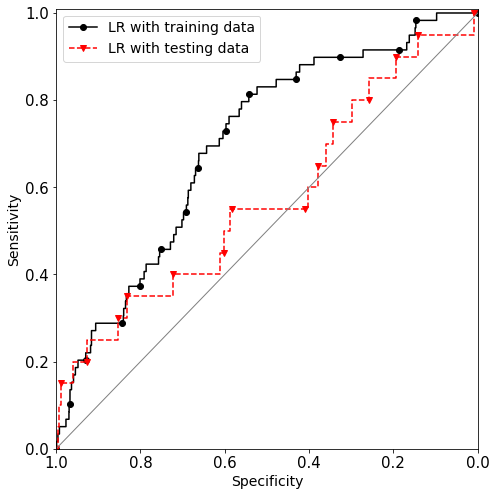

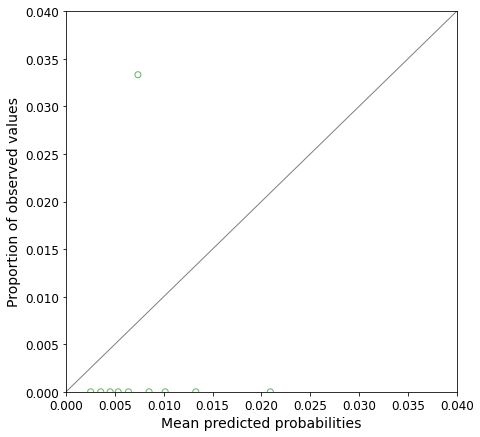

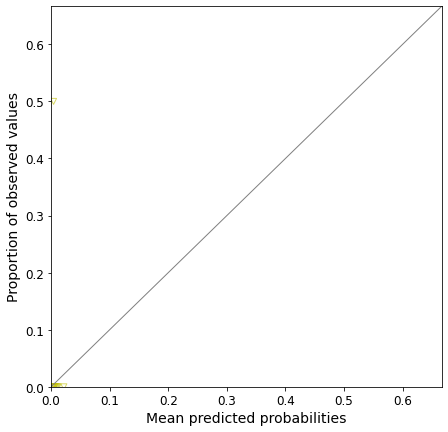

In [73]:
#data prep for lr
data, data_sinusitis_abs_incdt_enc = cox_data_prep(data_sinusitis_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

#build lr model
lr_sinusitis_abs_incdt, data_sinusitis_abs_incdt_lr_y_train, pred_proba_sinusitis_abs_incdt_train, data_sinusitis_abs_incdt_lr_y_test, pred_proba_sinusitis_abs_incdt_test = lr_model_build('sinusitis', 'abs_incdt', data_sinusitis_abs_incdt, data_sinusitis_abs_incdt_enc)

#save betas of lr model
lr_betas(lr_sinusitis_abs_incdt, 'sinusitis', 'abs_incdt')

#plot roc curev of lr model
lr_roc_curve('sinusitis', 'abs_incdt', data_sinusitis_abs_incdt_lr_y_train, pred_proba_sinusitis_abs_incdt_train, data_sinusitis_abs_incdt_lr_y_test, pred_proba_sinusitis_abs_incdt_test)

#plot calibration of lr model
lr_pred_calib('sinusitis', 'abs_incdt', data_sinusitis_abs_incdt_train, pred_proba_sinusitis_abs_incdt_train, data_sinusitis_abs_incdt_test, pred_proba_sinusitis_abs_incdt_test)

#save auroc and brier of lr model
lr_auroc_brier('sinusitis', 'abs_incdt', data_sinusitis_abs_incdt_lr_y_train, pred_proba_sinusitis_abs_incdt_train, data_sinusitis_abs_incdt_lr_y_test, pred_proba_sinusitis_abs_incdt_test)

### 6-3- prevalent sinusitis with no antibiotics

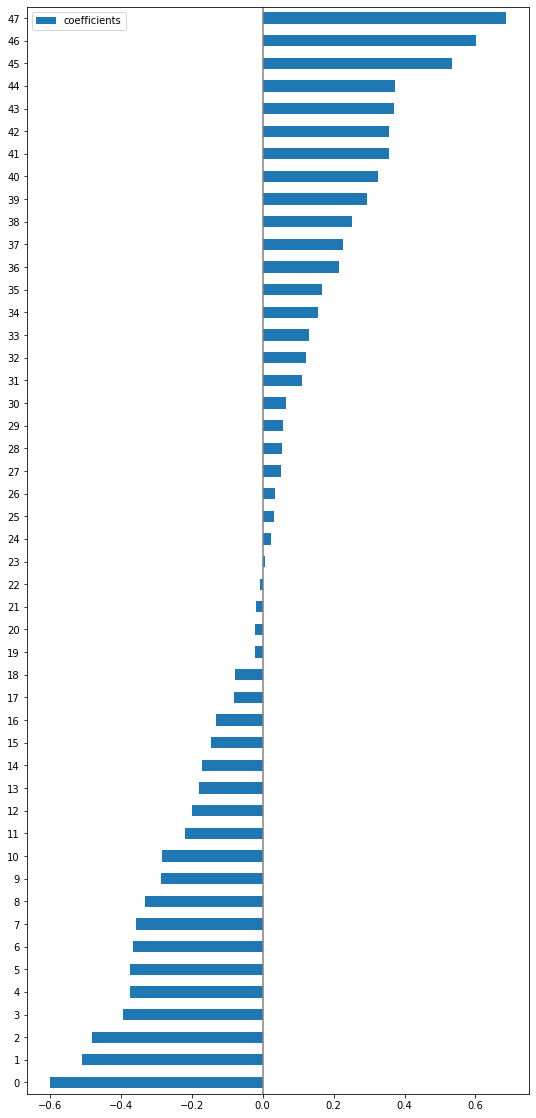

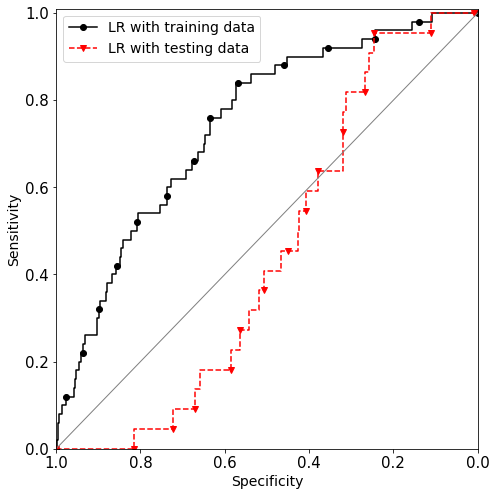

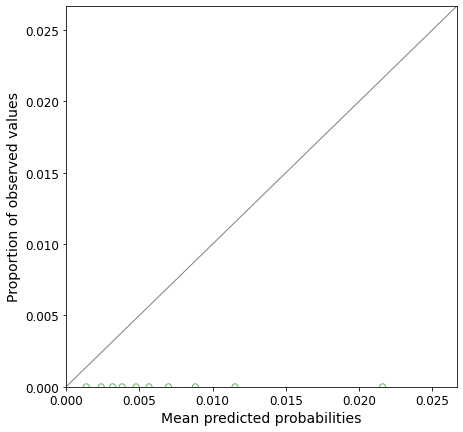

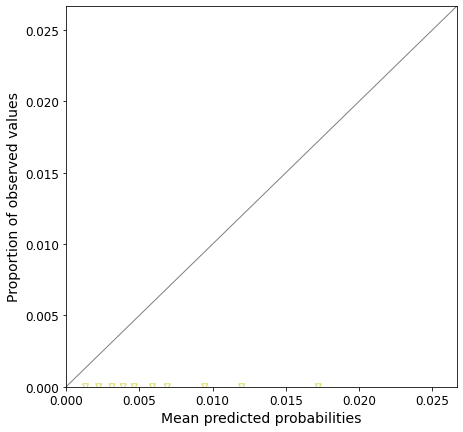

In [74]:
#data prep for lr
data, data_sinusitis_no_abs_prevl_enc = cox_data_prep(data_sinusitis_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

#build lr model
lr_sinusitis_no_abs_prevl, data_sinusitis_no_abs_prevl_lr_y_train, pred_proba_sinusitis_no_abs_prevl_train, data_sinusitis_no_abs_prevl_lr_y_test, pred_proba_sinusitis_no_abs_prevl_test = lr_model_build('sinusitis', 'no_abs_prevl', data_sinusitis_no_abs_prevl, data_sinusitis_no_abs_prevl_enc)

#save betas of lr model
lr_betas(lr_sinusitis_no_abs_prevl, 'sinusitis', 'no_abs_prevl')

#plot roc curev of lr model
lr_roc_curve('sinusitis', 'no_abs_prevl', data_sinusitis_no_abs_prevl_lr_y_train, pred_proba_sinusitis_no_abs_prevl_train, data_sinusitis_no_abs_prevl_lr_y_test, pred_proba_sinusitis_no_abs_prevl_test)

#plot calibration of lr model
lr_pred_calib('sinusitis', 'no_abs_prevl', data_sinusitis_no_abs_prevl_train, pred_proba_sinusitis_no_abs_prevl_train, data_sinusitis_no_abs_prevl_test, pred_proba_sinusitis_no_abs_prevl_test)

#save auroc and brier of lr model
lr_auroc_brier('sinusitis', 'no_abs_prevl', data_sinusitis_no_abs_prevl_lr_y_train, pred_proba_sinusitis_no_abs_prevl_train, data_sinusitis_no_abs_prevl_lr_y_test, pred_proba_sinusitis_no_abs_prevl_test)

### 6-4- prevalent sinusitis with antibiotics

In [75]:
# #data prep for lr
# data, data_sinusitis_abs_prevl_enc = cox_data_prep(data_sinusitis_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

# #build lr model
# lr_sinusitis_abs_prevl, data_sinusitis_abs_prevl_lr_y_train, pred_proba_sinusitis_abs_prevl_train, data_sinusitis_abs_prevl_lr_y_test, pred_proba_sinusitis_abs_prevl_test = lr_model_build('sinusitis', 'abs_prevl', data_sinusitis_abs_prevl, data_sinusitis_abs_prevl_enc)

# #save betas of lr model
# lr_betas(lr_sinusitis_abs_prevl, 'sinusitis', 'abs_prevl')

# #plot roc curev of lr model
# lr_roc_curve('sinusitis', 'abs_prevl', data_sinusitis_abs_prevl_lr_y_train, pred_proba_sinusitis_abs_prevl_train, data_sinusitis_abs_prevl_lr_y_test, pred_proba_sinusitis_abs_prevl_test)

# #plot calibration of lr model
# lr_pred_calib('sinusitis', 'abs_prevl', data_sinusitis_abs_prevl_train, pred_proba_sinusitis_abs_prevl_train, data_sinusitis_abs_prevl_test, pred_proba_sinusitis_abs_prevl_test)

# #save auroc and brier of lr model
# lr_auroc_brier('sinusitis', 'abs_prevl', data_sinusitis_abs_prevl_lr_y_train, pred_proba_sinusitis_abs_prevl_train, data_sinusitis_abs_prevl_lr_y_test, pred_proba_sinusitis_abs_prevl_test)